# Load data

In [1]:
import pandas as pd
from constants import NULLABLE_MEASURES
from utils.class_patient import Patients

patients = Patients.loadPatients()
patients.fillMissingMeasureValue(NULLABLE_MEASURES, 0)

# Remove missing data

## Remove features with more than 20% missing

In [2]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


## Remove patients with more than 20% missing features

In [3]:
patients.removePatientByMissingFeatures()
len(patients)

1206

## Display insight

In [4]:
# dfData = patients.getMeasuresBetween(pd.Timedelta(hours=-6), pd.Timedelta(hours=24), "first")

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(patients.getMeasures())

Counter({'age': 1206,
         'chronic_pulmonary_disease': 1206,
         'ckd_stage': 1206,
         'congestive_heart_failure': 1206,
         'dka_type': 1206,
         'gender': 1206,
         'history_aci': 1206,
         'history_ami': 1206,
         'hypertension': 1206,
         'liver_disease': 1206,
         'macroangiopathy': 1206,
         'malignant_cancer': 1206,
         'mechanical_ventilation': 1206,
         'microangiopathy': 1206,
         'oasis': 1206,
         'preiculos': 1206,
         'race': 1206,
         'saps2': 1206,
         'sofa': 1206,
         'use_NaHCO3': 1206,
         'uti': 1206,
         'ag': 1205,
         'bg': 1205,
         'bicarbonate': 1205,
         'bun': 1205,
         'chloride': 1205,
         'egfr': 1205,
         'hr': 1205,
         'potassium': 1205,
         'scr': 1205,
         'sodium': 1205,
         'dbp': 1204,
         'gcs': 1204,
         'gcs_unable': 1204,
         'rr': 1204,
         'sbp': 1204,
         'calci

In [5]:
akdCount = sum([p.akdPositive for p in patients.patientList])

akdCount / len(patients)

0.39303482587064675

# Machine learning

In [6]:
from constants import CATEGORICAL_MEASURES


idColumns = ["subject_id", "hadm_id", "stay_id"]
categoryColumns = CATEGORICAL_MEASURES
labelColumn = "akd"

## Split train-test

In [7]:
splitedPatients = patients.split(5, 27)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

## Define model

In [8]:
import xgboost as xgb

how = "first"

params = {
    "validate_parameters": True,
    "device": "gpu",  # Use GPU acceleration
    "n_jobs": -1,  # Use all CPU cores
    "eval_metric": "logloss",  # Evaluation metric
    "max_depth": 6,  # Maximum depth of a tree
    "min_child_weight": 1,  # Minimum sum of instance weight (hessian) needed in a child
    "gamma": 0,  # Minimum loss reduction required to make a further partition on a leaf node
    "subsample": 0.8,  # Subsample ratio of the training instances
    "colsample_bytree": 0.8,  # Subsample ratio of columns when constructing each tree
    "reg_alpha": 0.01,  # L1 regularization term on weights
    "reg_lambda": 1,  # L2 regularization term on weights
    "objective": "binary:logistic",  # Binary classification objective
    "n_estimators": 1000,  # Number of trees
    "learning_rate": 0.01,  # Learning rate
    "early_stopping_rounds": 10,  # Early stopping
    "verbose": 0,  # Verbosity
}


def createModel():
    model = xgb.XGBClassifier(**params)
    return model

`functionize-notebook` has modified this notebook during execution. The following variables have been injected:

- how: avg


## Without validate

### Without fill missing data

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from utils.prepare_data import normalizeData


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list.append(accuracy_score(y_test, y_pred))
    precision_score_list.append(precision_score(y_test, y_pred))
    recall_score_list.append(recall_score(y_test, y_pred))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))

/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:10:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:10:34] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:10:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:11:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:11:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:11:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:

print(f"Average AUC: {np.mean(auc_score_list)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list)}")
print(f"Average Precision: {np.mean(precision_score_list)}")
print(f"Average Recall: {np.mean(recall_score_list)}")

Average AUC: 0.8265556404647793
Average Accuracy: 0.7503926477144132
Average Precision: 0.7070062474377841
Average Recall: 0.624501679731243


### Fill missing with knn

In [12]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_knn = []
precision_score_list_knn = []
recall_score_list_knn = []
auc_score_list_knn = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeAndFillData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_knn.append(precision_score(y_test, y_pred))
    recall_score_list_knn.append(recall_score(y_test, y_pred))
    auc_score_list_knn.append(roc_auc_score(y_test, y_pred_proba))

/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:11:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:12:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:12:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:12:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:13:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [13]:

print(f"Average AUC: {np.mean(auc_score_list_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_knn)}")

Average AUC: 0.8017453071826838
Average Accuracy: 0.7346490175234045
Average Precision: 0.6880151309846433
Average Recall: 0.5992609182530795


## With validate

### Without fill missing data

In [14]:
from utils.prepare_data import normalizeData


accuracy_score_list_val = []
precision_score_list_val = []
recall_score_list_val = []
auc_score_list_val = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn]) # type: ignore
    y_val = dfVal[labelColumn] # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val.append(accuracy_score(y_test, y_pred))
    precision_score_list_val.append(precision_score(y_test, y_pred))
    recall_score_list_val.append(recall_score(y_test, y_pred))
    auc_score_list_val.append(roc_auc_score(y_test, y_pred_proba))

[0]	validation_0-logloss:0.66609


[1]	validation_0-logloss:0.66311


[2]	validation_0-logloss:0.66051


[3]	validation_0-logloss:0.65793


[4]	validation_0-logloss:0.65562


[5]	validation_0-logloss:0.65317


[6]	validation_0-logloss:0.65062


[7]	validation_0-logloss:0.64846


[8]	validation_0-logloss:0.64607


[9]	validation_0-logloss:0.64384


[10]	validation_0-logloss:0.64086


[11]	validation_0-logloss:0.63844


[12]	validation_0-logloss:0.63644


[13]	validation_0-logloss:0.63448


[14]	validation_0-logloss:0.63248


[15]	validation_0-logloss:0.63042


[16]	validation_0-logloss:0.62853


[17]	validation_0-logloss:0.62710


[18]	validation_0-logloss:0.62475


[19]	validation_0-logloss:0.62256


[20]	validation_0-logloss:0.62018


[21]	validation_0-logloss:0.61833


[22]	validation_0-logloss:0.61637


[23]	validation_0-logloss:0.61476


[24]	validation_0-logloss:0.61274


[25]	validation_0-logloss:0.61056


[26]	validation_0-logloss:0.60925


[27]	validation_0-logloss:0.60766


[28]	validation_0-logloss:0.60618


[29]	validation_0-logloss:0.60423


[30]	validation_0-logloss:0.60328


[31]	validation_0-logloss:0.60169


[32]	validation_0-logloss:0.60025


[33]	validation_0-logloss:0.59866


[34]	validation_0-logloss:0.59734


[35]	validation_0-logloss:0.59558


[36]	validation_0-logloss:0.59380


[37]	validation_0-logloss:0.59236


[38]	validation_0-logloss:0.59133


[39]	validation_0-logloss:0.58939


[40]	validation_0-logloss:0.58723


[41]	validation_0-logloss:0.58653


[42]	validation_0-logloss:0.58504


[43]	validation_0-logloss:0.58393


[44]	validation_0-logloss:0.58199


[45]	validation_0-logloss:0.58087


[46]	validation_0-logloss:0.57962


[47]	validation_0-logloss:0.57815


[48]	validation_0-logloss:0.57731


[49]	validation_0-logloss:0.57580


[50]	validation_0-logloss:0.57471


[51]	validation_0-logloss:0.57327


[52]	validation_0-logloss:0.57208


[53]	validation_0-logloss:0.57072


[54]	validation_0-logloss:0.56936


[55]	validation_0-logloss:0.56779


[56]	validation_0-logloss:0.56684


[57]	validation_0-logloss:0.56629


[58]	validation_0-logloss:0.56504


[59]	validation_0-logloss:0.56436


[60]	validation_0-logloss:0.56346


[61]	validation_0-logloss:0.56227


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:13:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[62]	validation_0-logloss:0.56123


[63]	validation_0-logloss:0.56009


[64]	validation_0-logloss:0.55921


[65]	validation_0-logloss:0.55785


[66]	validation_0-logloss:0.55712


[67]	validation_0-logloss:0.55659


[68]	validation_0-logloss:0.55573


[69]	validation_0-logloss:0.55459


[70]	validation_0-logloss:0.55324


[71]	validation_0-logloss:0.55240


[72]	validation_0-logloss:0.55184


[73]	validation_0-logloss:0.55106


[74]	validation_0-logloss:0.54982


[75]	validation_0-logloss:0.54931


[76]	validation_0-logloss:0.54858


[77]	validation_0-logloss:0.54761


[78]	validation_0-logloss:0.54690


[79]	validation_0-logloss:0.54582


[80]	validation_0-logloss:0.54466


[81]	validation_0-logloss:0.54388


[82]	validation_0-logloss:0.54270


[83]	validation_0-logloss:0.54163


[84]	validation_0-logloss:0.54061


[85]	validation_0-logloss:0.53931


[86]	validation_0-logloss:0.53842


[87]	validation_0-logloss:0.53767


[88]	validation_0-logloss:0.53668


[89]	validation_0-logloss:0.53656


[90]	validation_0-logloss:0.53545


[91]	validation_0-logloss:0.53489


[92]	validation_0-logloss:0.53353


[93]	validation_0-logloss:0.53257


[94]	validation_0-logloss:0.53229


[95]	validation_0-logloss:0.53149


[96]	validation_0-logloss:0.53042


[97]	validation_0-logloss:0.52984


[98]	validation_0-logloss:0.52971


[99]	validation_0-logloss:0.52889


[100]	validation_0-logloss:0.52846


[101]	validation_0-logloss:0.52792


[102]	validation_0-logloss:0.52723


[103]	validation_0-logloss:0.52667


[104]	validation_0-logloss:0.52600


[105]	validation_0-logloss:0.52555

[106]	validation_0-logloss:0.52530


[107]	validation_0-logloss:0.52494


[108]	validation_0-logloss:0.52470


[109]	validation_0-logloss:0.52424


[110]	validation_0-logloss:0.52405


[111]	validation_0-logloss:0.52368


[112]	validation_0-logloss:0.52314


[113]	validation_0-logloss:0.52274


[114]	validation_0-logloss:0.52208


[115]	validation_0-logloss:0.52145


[116]	validation_0-logloss:0.52129


[117]	validation_0-logloss:0.52097


[118]	validation_0-logloss:0.52073


[119]	validation_0-logloss:0.52042


[120]	validation_0-logloss:0.51973


[121]	validation_0-logloss:0.51951


[122]	validation_0-logloss:0.51922

[123]	validation_0-logloss:0.51848


[124]	validation_0-logloss:0.51816


[125]	validation_0-logloss:0.51788


[126]	validation_0-logloss:0.51733


[127]	validation_0-logloss:0.51722


[128]	validation_0-logloss:0.51717


[129]	validation_0-logloss:0.51674


[130]	validation_0-logloss:0.51597


[131]	validation_0-logloss:0.51579


[132]	validation_0-logloss:0.51519


[133]	validation_0-logloss:0.51493


[134]	validation_0-logloss:0.51454


[135]	validation_0-logloss:0.51373


[136]	validation_0-logloss:0.51344


[137]	validation_0-logloss:0.51293


[138]	validation_0-logloss:0.51279


[139]	validation_0-logloss:0.51202


[140]	validation_0-logloss:0.51191


[141]	validation_0-logloss:0.51165


[142]	validation_0-logloss:0.51120


[143]	validation_0-logloss:0.51081


[144]	validation_0-logloss:0.51074


[145]	validation_0-logloss:0.51073


[146]	validation_0-logloss:0.51046


[147]	validation_0-logloss:0.51000


[148]	validation_0-logloss:0.50955


[149]	validation_0-logloss:0.50936


[150]	validation_0-logloss:0.50902


[151]	validation_0-logloss:0.50870


[152]	validation_0-logloss:0.50830


[153]	validation_0-logloss:0.50773


[154]	validation_0-logloss:0.50692


[155]	validation_0-logloss:0.50659


[156]	validation_0-logloss:0.50618


[157]	validation_0-logloss:0.50568


[158]	validation_0-logloss:0.50514


[159]	validation_0-logloss:0.50459


[160]	validation_0-logloss:0.50468


[161]	validation_0-logloss:0.50446


[162]	validation_0-logloss:0.50429


[163]	validation_0-logloss:0.50398


[164]	validation_0-logloss:0.50348


[165]	validation_0-logloss:0.50323


[166]	validation_0-logloss:0.50300


[167]	validation_0-logloss:0.50283


[168]	validation_0-logloss:0.50297


[169]	validation_0-logloss:0.50277


[170]	validation_0-logloss:0.50222


[171]	validation_0-logloss:0.50219


[172]	validation_0-logloss:0.50190


[173]	validation_0-logloss:0.50188


[174]	validation_0-logloss:0.50171


[175]	validation_0-logloss:0.50155


[176]	validation_0-logloss:0.50148

[177]	validation_0-logloss:0.50101


[178]	validation_0-logloss:0.50067


[179]	validation_0-logloss:0.50028


[180]	validation_0-logloss:0.50009


[181]	validation_0-logloss:0.50019


[182]	validation_0-logloss:0.50007


[183]	validation_0-logloss:0.49988

[184]	validation_0-logloss:0.49952


[185]	validation_0-logloss:0.49933


[186]	validation_0-logloss:0.49910


[187]	validation_0-logloss:0.49886


[188]	validation_0-logloss:0.49869


[189]	validation_0-logloss:0.49852


[190]	validation_0-logloss:0.49787


[191]	validation_0-logloss:0.49757


[192]	validation_0-logloss:0.49735

[193]	validation_0-logloss:0.49736


[194]	validation_0-logloss:0.49723

[195]	validation_0-logloss:0.49688


[196]	validation_0-logloss:0.49692


[197]	validation_0-logloss:0.49691


[198]	validation_0-logloss:0.49677


[199]	validation_0-logloss:0.49656


[200]	validation_0-logloss:0.49619


[201]	validation_0-logloss:0.49604


[202]	validation_0-logloss:0.49598


[203]	validation_0-logloss:0.49519


[204]	validation_0-logloss:0.49525


[205]	validation_0-logloss:0.49528


[206]	validation_0-logloss:0.49501


[207]	validation_0-logloss:0.49501


[208]	validation_0-logloss:0.49472


[209]	validation_0-logloss:0.49495

[210]	validation_0-logloss:0.49494


[211]	validation_0-logloss:0.49455


[212]	validation_0-logloss:0.49446


[213]	validation_0-logloss:0.49451


[214]	validation_0-logloss:0.49464


[215]	validation_0-logloss:0.49457


[216]	validation_0-logloss:0.49445


[217]	validation_0-logloss:0.49399

[218]	validation_0-logloss:0.49403


[219]	validation_0-logloss:0.49389


[220]	validation_0-logloss:0.49374


[221]	validation_0-logloss:0.49386


[222]	validation_0-logloss:0.49368


[223]	validation_0-logloss:0.49341


[224]	validation_0-logloss:0.49368


[225]	validation_0-logloss:0.49362


[226]	validation_0-logloss:0.49312


[227]	validation_0-logloss:0.49312


[228]	validation_0-logloss:0.49293


[229]	validation_0-logloss:0.49306


[230]	validation_0-logloss:0.49314


[231]	validation_0-logloss:0.49324


[232]	validation_0-logloss:0.49317

[233]	validation_0-logloss:0.49308


[234]	validation_0-logloss:0.49305


[235]	validation_0-logloss:0.49278


[236]	validation_0-logloss:0.49283

[237]	validation_0-logloss:0.49297


[238]	validation_0-logloss:0.49310


[239]	validation_0-logloss:0.49303


[240]	validation_0-logloss:0.49318


[241]	validation_0-logloss:0.49296


[242]	validation_0-logloss:0.49270


[243]	validation_0-logloss:0.49272


[244]	validation_0-logloss:0.49252


[245]	validation_0-logloss:0.49260


[246]	validation_0-logloss:0.49237


[247]	validation_0-logloss:0.49219


[248]	validation_0-logloss:0.49220


[249]	validation_0-logloss:0.49211


[250]	validation_0-logloss:0.49202


[251]	validation_0-logloss:0.49197


[252]	validation_0-logloss:0.49195


[253]	validation_0-logloss:0.49194


[254]	validation_0-logloss:0.49177


[255]	validation_0-logloss:0.49138


[256]	validation_0-logloss:0.49122


[257]	validation_0-logloss:0.49135


[258]	validation_0-logloss:0.49104


[259]	validation_0-logloss:0.49093


[260]	validation_0-logloss:0.49091


[261]	validation_0-logloss:0.49094


[262]	validation_0-logloss:0.49064


[263]	validation_0-logloss:0.49057


[264]	validation_0-logloss:0.49055


[265]	validation_0-logloss:0.49047

[266]	validation_0-logloss:0.49049


[267]	validation_0-logloss:0.49008


[268]	validation_0-logloss:0.49005


[269]	validation_0-logloss:0.48999


[270]	validation_0-logloss:0.49000


[271]	validation_0-logloss:0.48989


[272]	validation_0-logloss:0.48979


[273]	validation_0-logloss:0.48975


[274]	validation_0-logloss:0.48922


[275]	validation_0-logloss:0.48896


[276]	validation_0-logloss:0.48878


[277]	validation_0-logloss:0.48850


[278]	validation_0-logloss:0.48849


[279]	validation_0-logloss:0.48817


[280]	validation_0-logloss:0.48819


[281]	validation_0-logloss:0.48821


[282]	validation_0-logloss:0.48834

[283]	validation_0-logloss:0.48828

[284]	validation_0-logloss:0.48819


[285]	validation_0-logloss:0.48802


[286]	validation_0-logloss:0.48784


[287]	validation_0-logloss:0.48785


[288]	validation_0-logloss:0.48765

[289]	validation_0-logloss:0.48792


[290]	validation_0-logloss:0.48803


[291]	validation_0-logloss:0.48800


[292]	validation_0-logloss:0.48797


[293]	validation_0-logloss:0.48820


[294]	validation_0-logloss:0.48795

[295]	validation_0-logloss:0.48805


[296]	validation_0-logloss:0.48822


[297]	validation_0-logloss:0.48847


[0]	validation_0-logloss:0.66785


[1]	validation_0-logloss:0.66508


[2]	validation_0-logloss:0.66304


[3]	validation_0-logloss:0.66065


[4]	validation_0-logloss:0.65754


[5]	validation_0-logloss:0.65489


[6]	validation_0-logloss:0.65207


[7]	validation_0-logloss:0.65033


[8]	validation_0-logloss:0.64828


[9]	validation_0-logloss:0.64566


[10]	validation_0-logloss:0.64375


[11]	validation_0-logloss:0.64223


[12]	validation_0-logloss:0.64049


[13]	validation_0-logloss:0.63870


[14]	validation_0-logloss:0.63624


[15]	validation_0-logloss:0.63411


[16]	validation_0-logloss:0.63217


[17]	validation_0-logloss:0.62970


[18]	validation_0-logloss:0.62768


[19]	validation_0-logloss:0.62609


[20]	validation_0-logloss:0.62422


[21]	validation_0-logloss:0.62209


[22]	validation_0-logloss:0.62007


[23]	validation_0-logloss:0.61811


[24]	validation_0-logloss:0.61618


[25]	validation_0-logloss:0.61458


[26]	validation_0-logloss:0.61306


[27]	validation_0-logloss:0.61150


[28]	validation_0-logloss:0.60953


[29]	validation_0-logloss:0.60779


[30]	validation_0-logloss:0.60626


[31]	validation_0-logloss:0.60457


[32]	validation_0-logloss:0.60317


[33]	validation_0-logloss:0.60192


[34]	validation_0-logloss:0.60060


[35]	validation_0-logloss:0.59887


[36]	validation_0-logloss:0.59725


[37]	validation_0-logloss:0.59561


[38]	validation_0-logloss:0.59389


[39]	validation_0-logloss:0.59222


[40]	validation_0-logloss:0.59111


[41]	validation_0-logloss:0.58995


[42]	validation_0-logloss:0.58874


[43]	validation_0-logloss:0.58752


[44]	validation_0-logloss:0.58581


[45]	validation_0-logloss:0.58457


[46]	validation_0-logloss:0.58308


[47]	validation_0-logloss:0.58207


[48]	validation_0-logloss:0.58021


[49]	validation_0-logloss:0.57876


[50]	validation_0-logloss:0.57758


[51]	validation_0-logloss:0.57637


[52]	validation_0-logloss:0.57568


[53]	validation_0-logloss:0.57453


[54]	validation_0-logloss:0.57313


[55]	validation_0-logloss:0.57210


[56]	validation_0-logloss:0.57099


[57]	validation_0-logloss:0.56949


[58]	validation_0-logloss:0.56796


[59]	validation_0-logloss:0.56667


[60]	validation_0-logloss:0.56570


[61]	validation_0-logloss:0.56483


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:14:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[62]	validation_0-logloss:0.56359


[63]	validation_0-logloss:0.56272


[64]	validation_0-logloss:0.56204


[65]	validation_0-logloss:0.56093


[66]	validation_0-logloss:0.55979

[67]	validation_0-logloss:0.55887


[68]	validation_0-logloss:0.55816


[69]	validation_0-logloss:0.55750


[70]	validation_0-logloss:0.55641


[71]	validation_0-logloss:0.55544


[72]	validation_0-logloss:0.55496

[73]	validation_0-logloss:0.55371


[74]	validation_0-logloss:0.55290


[75]	validation_0-logloss:0.55238


[76]	validation_0-logloss:0.55180


[77]	validation_0-logloss:0.55091


[78]	validation_0-logloss:0.55013


[79]	validation_0-logloss:0.54919


[80]	validation_0-logloss:0.54850


[81]	validation_0-logloss:0.54791


[82]	validation_0-logloss:0.54708


[83]	validation_0-logloss:0.54632


[84]	validation_0-logloss:0.54578


[85]	validation_0-logloss:0.54545


[86]	validation_0-logloss:0.54486


[87]	validation_0-logloss:0.54361


[88]	validation_0-logloss:0.54311

[89]	validation_0-logloss:0.54243


[90]	validation_0-logloss:0.54168


[91]	validation_0-logloss:0.54128


[92]	validation_0-logloss:0.54066

[93]	validation_0-logloss:0.54022


[94]	validation_0-logloss:0.53941


[95]	validation_0-logloss:0.53890


[96]	validation_0-logloss:0.53791


[97]	validation_0-logloss:0.53680


[98]	validation_0-logloss:0.53574


[99]	validation_0-logloss:0.53508


[100]	validation_0-logloss:0.53425

[101]	validation_0-logloss:0.53296

[102]	validation_0-logloss:0.53264


[103]	validation_0-logloss:0.53217


[104]	validation_0-logloss:0.53124


[105]	validation_0-logloss:0.53074


[106]	validation_0-logloss:0.53017


[107]	validation_0-logloss:0.52988


[108]	validation_0-logloss:0.52908


[109]	validation_0-logloss:0.52842


[110]	validation_0-logloss:0.52769


[111]	validation_0-logloss:0.52708


[112]	validation_0-logloss:0.52634


[113]	validation_0-logloss:0.52537


[114]	validation_0-logloss:0.52464


[115]	validation_0-logloss:0.52422


[116]	validation_0-logloss:0.52418


[117]	validation_0-logloss:0.52373


[118]	validation_0-logloss:0.52309


[119]	validation_0-logloss:0.52243


[120]	validation_0-logloss:0.52184


[121]	validation_0-logloss:0.52136


[122]	validation_0-logloss:0.52106


[123]	validation_0-logloss:0.52076


[124]	validation_0-logloss:0.52047


[125]	validation_0-logloss:0.51992


[126]	validation_0-logloss:0.51905


[127]	validation_0-logloss:0.51887


[128]	validation_0-logloss:0.51873


[129]	validation_0-logloss:0.51853


[130]	validation_0-logloss:0.51796


[131]	validation_0-logloss:0.51754


[132]	validation_0-logloss:0.51706

[133]	validation_0-logloss:0.51663


[134]	validation_0-logloss:0.51623

[135]	validation_0-logloss:0.51587


[136]	validation_0-logloss:0.51551


[137]	validation_0-logloss:0.51505

[138]	validation_0-logloss:0.51490


[139]	validation_0-logloss:0.51437


[140]	validation_0-logloss:0.51440


[141]	validation_0-logloss:0.51427


[142]	validation_0-logloss:0.51384


[143]	validation_0-logloss:0.51360

[144]	validation_0-logloss:0.51316


[145]	validation_0-logloss:0.51239


[146]	validation_0-logloss:0.51161


[147]	validation_0-logloss:0.51133


[148]	validation_0-logloss:0.51100


[149]	validation_0-logloss:0.51068


[150]	validation_0-logloss:0.51017


[151]	validation_0-logloss:0.50979


[152]	validation_0-logloss:0.50935

[153]	validation_0-logloss:0.50897


[154]	validation_0-logloss:0.50871


[155]	validation_0-logloss:0.50871


[156]	validation_0-logloss:0.50841


[157]	validation_0-logloss:0.50783


[158]	validation_0-logloss:0.50781


[159]	validation_0-logloss:0.50719


[160]	validation_0-logloss:0.50690


[161]	validation_0-logloss:0.50697


[162]	validation_0-logloss:0.50698


[163]	validation_0-logloss:0.50688


[164]	validation_0-logloss:0.50675


[165]	validation_0-logloss:0.50648


[166]	validation_0-logloss:0.50609


[167]	validation_0-logloss:0.50595


[168]	validation_0-logloss:0.50580


[169]	validation_0-logloss:0.50545


[170]	validation_0-logloss:0.50535


[171]	validation_0-logloss:0.50490


[172]	validation_0-logloss:0.50444


[173]	validation_0-logloss:0.50424


[174]	validation_0-logloss:0.50404


[175]	validation_0-logloss:0.50378


[176]	validation_0-logloss:0.50391


[177]	validation_0-logloss:0.50401


[178]	validation_0-logloss:0.50382


[179]	validation_0-logloss:0.50344


[180]	validation_0-logloss:0.50310


[181]	validation_0-logloss:0.50295

[182]	validation_0-logloss:0.50269


[183]	validation_0-logloss:0.50279


[184]	validation_0-logloss:0.50282


[185]	validation_0-logloss:0.50262


[186]	validation_0-logloss:0.50233


[187]	validation_0-logloss:0.50220


[188]	validation_0-logloss:0.50238


[189]	validation_0-logloss:0.50223


[190]	validation_0-logloss:0.50231


[191]	validation_0-logloss:0.50223

[192]	validation_0-logloss:0.50195


[193]	validation_0-logloss:0.50180


[194]	validation_0-logloss:0.50161


[195]	validation_0-logloss:0.50150


[196]	validation_0-logloss:0.50144


[197]	validation_0-logloss:0.50114


[198]	validation_0-logloss:0.50074


[199]	validation_0-logloss:0.50080

[200]	validation_0-logloss:0.50079


[201]	validation_0-logloss:0.50070


[202]	validation_0-logloss:0.50063


[203]	validation_0-logloss:0.50008


[204]	validation_0-logloss:0.49998


[205]	validation_0-logloss:0.49971


[206]	validation_0-logloss:0.49966


[207]	validation_0-logloss:0.49951


[208]	validation_0-logloss:0.49923


[209]	validation_0-logloss:0.49956


[210]	validation_0-logloss:0.49942


[211]	validation_0-logloss:0.49975


[212]	validation_0-logloss:0.49958


[213]	validation_0-logloss:0.49954


[214]	validation_0-logloss:0.49939


[215]	validation_0-logloss:0.49928


[216]	validation_0-logloss:0.49903


[217]	validation_0-logloss:0.49880


[218]	validation_0-logloss:0.49860


[219]	validation_0-logloss:0.49871


[220]	validation_0-logloss:0.49854


[221]	validation_0-logloss:0.49854


[222]	validation_0-logloss:0.49832


[223]	validation_0-logloss:0.49835


[224]	validation_0-logloss:0.49801


[225]	validation_0-logloss:0.49803


[226]	validation_0-logloss:0.49779


[227]	validation_0-logloss:0.49799


[228]	validation_0-logloss:0.49805


[229]	validation_0-logloss:0.49796


[230]	validation_0-logloss:0.49795


[231]	validation_0-logloss:0.49811


[232]	validation_0-logloss:0.49779


[233]	validation_0-logloss:0.49761


[234]	validation_0-logloss:0.49728


[235]	validation_0-logloss:0.49715


[236]	validation_0-logloss:0.49685


[237]	validation_0-logloss:0.49674


[238]	validation_0-logloss:0.49676


[239]	validation_0-logloss:0.49658


[240]	validation_0-logloss:0.49646


[241]	validation_0-logloss:0.49664


[242]	validation_0-logloss:0.49658

[243]	validation_0-logloss:0.49656


[244]	validation_0-logloss:0.49674

[245]	validation_0-logloss:0.49673


[246]	validation_0-logloss:0.49653


[247]	validation_0-logloss:0.49695


[248]	validation_0-logloss:0.49684


[249]	validation_0-logloss:0.49689


[250]	validation_0-logloss:0.49632


[251]	validation_0-logloss:0.49648


[252]	validation_0-logloss:0.49631

[253]	validation_0-logloss:0.49623


[254]	validation_0-logloss:0.49606


[255]	validation_0-logloss:0.49595

[256]	validation_0-logloss:0.49594


[257]	validation_0-logloss:0.49593


[258]	validation_0-logloss:0.49591


[259]	validation_0-logloss:0.49608


[260]	validation_0-logloss:0.49564

[261]	validation_0-logloss:0.49550

[262]	validation_0-logloss:0.49514


[263]	validation_0-logloss:0.49497


[264]	validation_0-logloss:0.49486


[265]	validation_0-logloss:0.49481


[266]	validation_0-logloss:0.49478


[267]	validation_0-logloss:0.49459


[268]	validation_0-logloss:0.49436


[269]	validation_0-logloss:0.49415


[270]	validation_0-logloss:0.49414


[271]	validation_0-logloss:0.49427


[272]	validation_0-logloss:0.49406


[273]	validation_0-logloss:0.49428


[274]	validation_0-logloss:0.49417


[275]	validation_0-logloss:0.49465


[276]	validation_0-logloss:0.49470


[277]	validation_0-logloss:0.49458


[278]	validation_0-logloss:0.49423


[279]	validation_0-logloss:0.49424


[280]	validation_0-logloss:0.49424


[281]	validation_0-logloss:0.49429

[282]	validation_0-logloss:0.49422


[0]	validation_0-logloss:0.66836


[1]	validation_0-logloss:0.66599


[2]	validation_0-logloss:0.66400


[3]	validation_0-logloss:0.66250


[4]	validation_0-logloss:0.66123


[5]	validation_0-logloss:0.65957


[6]	validation_0-logloss:0.65777


[7]	validation_0-logloss:0.65560


[8]	validation_0-logloss:0.65370


[9]	validation_0-logloss:0.65206


[10]	validation_0-logloss:0.64981


[11]	validation_0-logloss:0.64827


[12]	validation_0-logloss:0.64647


[13]	validation_0-logloss:0.64439


[14]	validation_0-logloss:0.64203


[15]	validation_0-logloss:0.63979


[16]	validation_0-logloss:0.63827


[17]	validation_0-logloss:0.63617


[18]	validation_0-logloss:0.63525


[19]	validation_0-logloss:0.63338


[20]	validation_0-logloss:0.63190


[21]	validation_0-logloss:0.63047


[22]	validation_0-logloss:0.62933


[23]	validation_0-logloss:0.62754


[24]	validation_0-logloss:0.62648


[25]	validation_0-logloss:0.62494


[26]	validation_0-logloss:0.62303


[27]	validation_0-logloss:0.62167


[28]	validation_0-logloss:0.62053


[29]	validation_0-logloss:0.61929


[30]	validation_0-logloss:0.61780


[31]	validation_0-logloss:0.61694


[32]	validation_0-logloss:0.61548


[33]	validation_0-logloss:0.61383


[34]	validation_0-logloss:0.61279


[35]	validation_0-logloss:0.61191


[36]	validation_0-logloss:0.61090


[37]	validation_0-logloss:0.60967


[38]	validation_0-logloss:0.60863


[39]	validation_0-logloss:0.60749


[40]	validation_0-logloss:0.60579


[41]	validation_0-logloss:0.60458


[42]	validation_0-logloss:0.60329


[43]	validation_0-logloss:0.60220


[44]	validation_0-logloss:0.60113


[45]	validation_0-logloss:0.60000


[46]	validation_0-logloss:0.59895


[47]	validation_0-logloss:0.59772


[48]	validation_0-logloss:0.59657


[49]	validation_0-logloss:0.59532


[50]	validation_0-logloss:0.59447


[51]	validation_0-logloss:0.59286


[52]	validation_0-logloss:0.59240


[53]	validation_0-logloss:0.59115


[54]	validation_0-logloss:0.59032


[55]	validation_0-logloss:0.58945


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:14:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[56]	validation_0-logloss:0.58854


[57]	validation_0-logloss:0.58828


[58]	validation_0-logloss:0.58746


[59]	validation_0-logloss:0.58710


[60]	validation_0-logloss:0.58630


[61]	validation_0-logloss:0.58525


[62]	validation_0-logloss:0.58419


[63]	validation_0-logloss:0.58297


[64]	validation_0-logloss:0.58280


[65]	validation_0-logloss:0.58191


[66]	validation_0-logloss:0.58124


[67]	validation_0-logloss:0.58034


[68]	validation_0-logloss:0.58009


[69]	validation_0-logloss:0.57921


[70]	validation_0-logloss:0.57853


[71]	validation_0-logloss:0.57813


[72]	validation_0-logloss:0.57701


[73]	validation_0-logloss:0.57586


[74]	validation_0-logloss:0.57476


[75]	validation_0-logloss:0.57438


[76]	validation_0-logloss:0.57403


[77]	validation_0-logloss:0.57337


[78]	validation_0-logloss:0.57254


[79]	validation_0-logloss:0.57215


[80]	validation_0-logloss:0.57132


[81]	validation_0-logloss:0.57030


[82]	validation_0-logloss:0.56941


[83]	validation_0-logloss:0.56829


[84]	validation_0-logloss:0.56718


[85]	validation_0-logloss:0.56702


[86]	validation_0-logloss:0.56631


[87]	validation_0-logloss:0.56581


[88]	validation_0-logloss:0.56480


[89]	validation_0-logloss:0.56442


[90]	validation_0-logloss:0.56363

[91]	validation_0-logloss:0.56299


[92]	validation_0-logloss:0.56246


[93]	validation_0-logloss:0.56245


[94]	validation_0-logloss:0.56205


[95]	validation_0-logloss:0.56137


[96]	validation_0-logloss:0.56109


[97]	validation_0-logloss:0.56089


[98]	validation_0-logloss:0.56058


[99]	validation_0-logloss:0.56014


[100]	validation_0-logloss:0.55992


[101]	validation_0-logloss:0.55957


[102]	validation_0-logloss:0.55925


[103]	validation_0-logloss:0.55859


[104]	validation_0-logloss:0.55760


[105]	validation_0-logloss:0.55663


[106]	validation_0-logloss:0.55603


[107]	validation_0-logloss:0.55546


[108]	validation_0-logloss:0.55460


[109]	validation_0-logloss:0.55435


[110]	validation_0-logloss:0.55378

[111]	validation_0-logloss:0.55361


[112]	validation_0-logloss:0.55293


[113]	validation_0-logloss:0.55230

[114]	validation_0-logloss:0.55209


[115]	validation_0-logloss:0.55170

[116]	validation_0-logloss:0.55130


[117]	validation_0-logloss:0.55080


[118]	validation_0-logloss:0.55020


[119]	validation_0-logloss:0.54983


[120]	validation_0-logloss:0.54992


[121]	validation_0-logloss:0.54985


[122]	validation_0-logloss:0.54944


[123]	validation_0-logloss:0.54894


[124]	validation_0-logloss:0.54826


[125]	validation_0-logloss:0.54813


[126]	validation_0-logloss:0.54792


[127]	validation_0-logloss:0.54751


[128]	validation_0-logloss:0.54679


[129]	validation_0-logloss:0.54685


[130]	validation_0-logloss:0.54682


[131]	validation_0-logloss:0.54637


[132]	validation_0-logloss:0.54573


[133]	validation_0-logloss:0.54543


[134]	validation_0-logloss:0.54501


[135]	validation_0-logloss:0.54446

[136]	validation_0-logloss:0.54408


[137]	validation_0-logloss:0.54356


[138]	validation_0-logloss:0.54293


[139]	validation_0-logloss:0.54295


[140]	validation_0-logloss:0.54252


[141]	validation_0-logloss:0.54232


[142]	validation_0-logloss:0.54192


[143]	validation_0-logloss:0.54142


[144]	validation_0-logloss:0.54135


[145]	validation_0-logloss:0.54124


[146]	validation_0-logloss:0.54066


[147]	validation_0-logloss:0.54086


[148]	validation_0-logloss:0.54064


[149]	validation_0-logloss:0.54067


[150]	validation_0-logloss:0.54044

[151]	validation_0-logloss:0.53991


[152]	validation_0-logloss:0.53980


[153]	validation_0-logloss:0.53989


[154]	validation_0-logloss:0.53949


[155]	validation_0-logloss:0.53923


[156]	validation_0-logloss:0.53871


[157]	validation_0-logloss:0.53826


[158]	validation_0-logloss:0.53787


[159]	validation_0-logloss:0.53754


[160]	validation_0-logloss:0.53727


[161]	validation_0-logloss:0.53686


[162]	validation_0-logloss:0.53673


[163]	validation_0-logloss:0.53681


[164]	validation_0-logloss:0.53655


[165]	validation_0-logloss:0.53604


[166]	validation_0-logloss:0.53557


[167]	validation_0-logloss:0.53508


[168]	validation_0-logloss:0.53480

[169]	validation_0-logloss:0.53471

[170]	validation_0-logloss:0.53451


[171]	validation_0-logloss:0.53446

[172]	validation_0-logloss:0.53390

[173]	validation_0-logloss:0.53360


[174]	validation_0-logloss:0.53349


[175]	validation_0-logloss:0.53318


[176]	validation_0-logloss:0.53290


[177]	validation_0-logloss:0.53270


[178]	validation_0-logloss:0.53246


[179]	validation_0-logloss:0.53268


[180]	validation_0-logloss:0.53214


[181]	validation_0-logloss:0.53190


[182]	validation_0-logloss:0.53172


[183]	validation_0-logloss:0.53172


[184]	validation_0-logloss:0.53117


[185]	validation_0-logloss:0.53115


[186]	validation_0-logloss:0.53081


[187]	validation_0-logloss:0.53081


[188]	validation_0-logloss:0.53097


[189]	validation_0-logloss:0.53095


[190]	validation_0-logloss:0.53043


[191]	validation_0-logloss:0.53048


[192]	validation_0-logloss:0.53044


[193]	validation_0-logloss:0.53044


[194]	validation_0-logloss:0.52996


[195]	validation_0-logloss:0.53001


[196]	validation_0-logloss:0.52969


[197]	validation_0-logloss:0.52936


[198]	validation_0-logloss:0.52929

[199]	validation_0-logloss:0.52925


[200]	validation_0-logloss:0.52905


[201]	validation_0-logloss:0.52905


[202]	validation_0-logloss:0.52846


[203]	validation_0-logloss:0.52846


[204]	validation_0-logloss:0.52843


[205]	validation_0-logloss:0.52849


[206]	validation_0-logloss:0.52848


[207]	validation_0-logloss:0.52801


[208]	validation_0-logloss:0.52807


[209]	validation_0-logloss:0.52776


[210]	validation_0-logloss:0.52776


[211]	validation_0-logloss:0.52739


[212]	validation_0-logloss:0.52693

[213]	validation_0-logloss:0.52716


[214]	validation_0-logloss:0.52728


[215]	validation_0-logloss:0.52679


[216]	validation_0-logloss:0.52625


[217]	validation_0-logloss:0.52608


[218]	validation_0-logloss:0.52602


[219]	validation_0-logloss:0.52617


[220]	validation_0-logloss:0.52602


[221]	validation_0-logloss:0.52593


[222]	validation_0-logloss:0.52578


[223]	validation_0-logloss:0.52568


[224]	validation_0-logloss:0.52554


[225]	validation_0-logloss:0.52500


[226]	validation_0-logloss:0.52509


[227]	validation_0-logloss:0.52515


[228]	validation_0-logloss:0.52521


[229]	validation_0-logloss:0.52510


[230]	validation_0-logloss:0.52511


[231]	validation_0-logloss:0.52477


[232]	validation_0-logloss:0.52518


[233]	validation_0-logloss:0.52528


[234]	validation_0-logloss:0.52497


[235]	validation_0-logloss:0.52512

[236]	validation_0-logloss:0.52511

[237]	validation_0-logloss:0.52525

[238]	validation_0-logloss:0.52503


[239]	validation_0-logloss:0.52459

[240]	validation_0-logloss:0.52465


[241]	validation_0-logloss:0.52479


[242]	validation_0-logloss:0.52470


[243]	validation_0-logloss:0.52514


[244]	validation_0-logloss:0.52523


[245]	validation_0-logloss:0.52561


[246]	validation_0-logloss:0.52557

[247]	validation_0-logloss:0.52533


[248]	validation_0-logloss:0.52563


[249]	validation_0-logloss:0.52543


[0]	validation_0-logloss:0.66832


[1]	validation_0-logloss:0.66581


[2]	validation_0-logloss:0.66371


[3]	validation_0-logloss:0.66151


[4]	validation_0-logloss:0.65932


[5]	validation_0-logloss:0.65770


[6]	validation_0-logloss:0.65563


[7]	validation_0-logloss:0.65391


[8]	validation_0-logloss:0.65242


[9]	validation_0-logloss:0.65087


[10]	validation_0-logloss:0.64916


[11]	validation_0-logloss:0.64674


[12]	validation_0-logloss:0.64513


[13]	validation_0-logloss:0.64275


[14]	validation_0-logloss:0.64046


[15]	validation_0-logloss:0.63840


[16]	validation_0-logloss:0.63621


[17]	validation_0-logloss:0.63391


[18]	validation_0-logloss:0.63231


[19]	validation_0-logloss:0.63119


[20]	validation_0-logloss:0.62950


[21]	validation_0-logloss:0.62868


[22]	validation_0-logloss:0.62727


[23]	validation_0-logloss:0.62528


[24]	validation_0-logloss:0.62351


[25]	validation_0-logloss:0.62201


[26]	validation_0-logloss:0.62075


[27]	validation_0-logloss:0.61910


[28]	validation_0-logloss:0.61766


[29]	validation_0-logloss:0.61588


[30]	validation_0-logloss:0.61417


[31]	validation_0-logloss:0.61307


[32]	validation_0-logloss:0.61198


[33]	validation_0-logloss:0.61065


[34]	validation_0-logloss:0.60941


[35]	validation_0-logloss:0.60782


[36]	validation_0-logloss:0.60565


[37]	validation_0-logloss:0.60451


[38]	validation_0-logloss:0.60363


[39]	validation_0-logloss:0.60242


[40]	validation_0-logloss:0.60124


[41]	validation_0-logloss:0.60016


[42]	validation_0-logloss:0.59944


[43]	validation_0-logloss:0.59859


[44]	validation_0-logloss:0.59737


[45]	validation_0-logloss:0.59619


[46]	validation_0-logloss:0.59508


[47]	validation_0-logloss:0.59450


[48]	validation_0-logloss:0.59342


[49]	validation_0-logloss:0.59245


[50]	validation_0-logloss:0.59194


[51]	validation_0-logloss:0.59101


[52]	validation_0-logloss:0.59014


[53]	validation_0-logloss:0.58904


[54]	validation_0-logloss:0.58865


[55]	validation_0-logloss:0.58732


[56]	validation_0-logloss:0.58635


[57]	validation_0-logloss:0.58522


[58]	validation_0-logloss:0.58385


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:14:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[59]	validation_0-logloss:0.58340


[60]	validation_0-logloss:0.58214


[61]	validation_0-logloss:0.58091


[62]	validation_0-logloss:0.57920


[63]	validation_0-logloss:0.57873


[64]	validation_0-logloss:0.57778


[65]	validation_0-logloss:0.57666


[66]	validation_0-logloss:0.57570


[67]	validation_0-logloss:0.57444


[68]	validation_0-logloss:0.57354


[69]	validation_0-logloss:0.57253


[70]	validation_0-logloss:0.57135


[71]	validation_0-logloss:0.57035


[72]	validation_0-logloss:0.56967


[73]	validation_0-logloss:0.56835


[74]	validation_0-logloss:0.56757


[75]	validation_0-logloss:0.56692


[76]	validation_0-logloss:0.56593


[77]	validation_0-logloss:0.56523


[78]	validation_0-logloss:0.56387


[79]	validation_0-logloss:0.56280


[80]	validation_0-logloss:0.56173


[81]	validation_0-logloss:0.56132


[82]	validation_0-logloss:0.56021


[83]	validation_0-logloss:0.55965


[84]	validation_0-logloss:0.55889


[85]	validation_0-logloss:0.55797


[86]	validation_0-logloss:0.55719


[87]	validation_0-logloss:0.55683


[88]	validation_0-logloss:0.55636


[89]	validation_0-logloss:0.55592


[90]	validation_0-logloss:0.55551

[91]	validation_0-logloss:0.55443


[92]	validation_0-logloss:0.55404


[93]	validation_0-logloss:0.55330


[94]	validation_0-logloss:0.55272

[95]	validation_0-logloss:0.55182


[96]	validation_0-logloss:0.55068


[97]	validation_0-logloss:0.55010


[98]	validation_0-logloss:0.54981


[99]	validation_0-logloss:0.54880


[100]	validation_0-logloss:0.54826


[101]	validation_0-logloss:0.54723


[102]	validation_0-logloss:0.54709


[103]	validation_0-logloss:0.54646


[104]	validation_0-logloss:0.54575


[105]	validation_0-logloss:0.54507


[106]	validation_0-logloss:0.54462


[107]	validation_0-logloss:0.54430


[108]	validation_0-logloss:0.54363


[109]	validation_0-logloss:0.54319


[110]	validation_0-logloss:0.54276


[111]	validation_0-logloss:0.54220


[112]	validation_0-logloss:0.54183


[113]	validation_0-logloss:0.54132


[114]	validation_0-logloss:0.54069


[115]	validation_0-logloss:0.54043


[116]	validation_0-logloss:0.54004


[117]	validation_0-logloss:0.54000


[118]	validation_0-logloss:0.53954

[119]	validation_0-logloss:0.53910


[120]	validation_0-logloss:0.53832


[121]	validation_0-logloss:0.53811


[122]	validation_0-logloss:0.53746


[123]	validation_0-logloss:0.53713


[124]	validation_0-logloss:0.53661


[125]	validation_0-logloss:0.53597


[126]	validation_0-logloss:0.53519


[127]	validation_0-logloss:0.53476


[128]	validation_0-logloss:0.53491


[129]	validation_0-logloss:0.53458


[130]	validation_0-logloss:0.53459


[131]	validation_0-logloss:0.53406


[132]	validation_0-logloss:0.53369


[133]	validation_0-logloss:0.53330


[134]	validation_0-logloss:0.53286


[135]	validation_0-logloss:0.53258


[136]	validation_0-logloss:0.53232


[137]	validation_0-logloss:0.53180


[138]	validation_0-logloss:0.53142


[139]	validation_0-logloss:0.53133


[140]	validation_0-logloss:0.53089


[141]	validation_0-logloss:0.53048


[142]	validation_0-logloss:0.53023


[143]	validation_0-logloss:0.52997

[144]	validation_0-logloss:0.52990


[145]	validation_0-logloss:0.52955

[146]	validation_0-logloss:0.52908


[147]	validation_0-logloss:0.52875


[148]	validation_0-logloss:0.52825


[149]	validation_0-logloss:0.52780


[150]	validation_0-logloss:0.52723


[151]	validation_0-logloss:0.52696


[152]	validation_0-logloss:0.52659


[153]	validation_0-logloss:0.52647


[154]	validation_0-logloss:0.52622


[155]	validation_0-logloss:0.52571


[156]	validation_0-logloss:0.52566


[157]	validation_0-logloss:0.52548


[158]	validation_0-logloss:0.52509


[159]	validation_0-logloss:0.52440


[160]	validation_0-logloss:0.52405


[161]	validation_0-logloss:0.52375


[162]	validation_0-logloss:0.52365


[163]	validation_0-logloss:0.52350


[164]	validation_0-logloss:0.52300


[165]	validation_0-logloss:0.52282


[166]	validation_0-logloss:0.52271


[167]	validation_0-logloss:0.52238


[168]	validation_0-logloss:0.52237


[169]	validation_0-logloss:0.52216


[170]	validation_0-logloss:0.52205


[171]	validation_0-logloss:0.52173


[172]	validation_0-logloss:0.52123


[173]	validation_0-logloss:0.52099


[174]	validation_0-logloss:0.52083


[175]	validation_0-logloss:0.52036


[176]	validation_0-logloss:0.52013


[177]	validation_0-logloss:0.51984


[178]	validation_0-logloss:0.51950

[179]	validation_0-logloss:0.51919


[180]	validation_0-logloss:0.51900


[181]	validation_0-logloss:0.51866


[182]	validation_0-logloss:0.51801


[183]	validation_0-logloss:0.51770


[184]	validation_0-logloss:0.51741


[185]	validation_0-logloss:0.51696

[186]	validation_0-logloss:0.51661


[187]	validation_0-logloss:0.51583


[188]	validation_0-logloss:0.51539


[189]	validation_0-logloss:0.51515


[190]	validation_0-logloss:0.51489


[191]	validation_0-logloss:0.51447


[192]	validation_0-logloss:0.51428


[193]	validation_0-logloss:0.51404


[194]	validation_0-logloss:0.51366


[195]	validation_0-logloss:0.51381


[196]	validation_0-logloss:0.51380


[197]	validation_0-logloss:0.51387


[198]	validation_0-logloss:0.51377


[199]	validation_0-logloss:0.51388


[200]	validation_0-logloss:0.51363


[201]	validation_0-logloss:0.51361


[202]	validation_0-logloss:0.51328


[203]	validation_0-logloss:0.51290


[204]	validation_0-logloss:0.51268


[205]	validation_0-logloss:0.51265


[206]	validation_0-logloss:0.51237


[207]	validation_0-logloss:0.51231


[208]	validation_0-logloss:0.51232


[209]	validation_0-logloss:0.51195


[210]	validation_0-logloss:0.51183


[211]	validation_0-logloss:0.51155


[212]	validation_0-logloss:0.51114


[213]	validation_0-logloss:0.51066


[214]	validation_0-logloss:0.51043


[215]	validation_0-logloss:0.51038


[216]	validation_0-logloss:0.51060


[217]	validation_0-logloss:0.51018


[218]	validation_0-logloss:0.50979


[219]	validation_0-logloss:0.50961


[220]	validation_0-logloss:0.50935


[221]	validation_0-logloss:0.50904


[222]	validation_0-logloss:0.50908


[223]	validation_0-logloss:0.50903


[224]	validation_0-logloss:0.50898


[225]	validation_0-logloss:0.50908


[226]	validation_0-logloss:0.50897


[227]	validation_0-logloss:0.50869


[228]	validation_0-logloss:0.50853


[229]	validation_0-logloss:0.50841


[230]	validation_0-logloss:0.50871


[231]	validation_0-logloss:0.50857


[232]	validation_0-logloss:0.50837

[233]	validation_0-logloss:0.50830


[234]	validation_0-logloss:0.50867


[235]	validation_0-logloss:0.50847


[236]	validation_0-logloss:0.50880


[237]	validation_0-logloss:0.50877


[238]	validation_0-logloss:0.50875


[239]	validation_0-logloss:0.50835


[240]	validation_0-logloss:0.50799


[241]	validation_0-logloss:0.50786


[242]	validation_0-logloss:0.50764


[243]	validation_0-logloss:0.50770


[244]	validation_0-logloss:0.50766


[245]	validation_0-logloss:0.50737


[246]	validation_0-logloss:0.50710

[247]	validation_0-logloss:0.50698


[248]	validation_0-logloss:0.50694


[249]	validation_0-logloss:0.50645


[250]	validation_0-logloss:0.50654


[251]	validation_0-logloss:0.50632


[252]	validation_0-logloss:0.50611


[253]	validation_0-logloss:0.50623


[254]	validation_0-logloss:0.50625


[255]	validation_0-logloss:0.50617


[256]	validation_0-logloss:0.50632


[257]	validation_0-logloss:0.50624


[258]	validation_0-logloss:0.50623

[259]	validation_0-logloss:0.50584


[260]	validation_0-logloss:0.50598


[261]	validation_0-logloss:0.50614


[262]	validation_0-logloss:0.50615


[263]	validation_0-logloss:0.50573


[264]	validation_0-logloss:0.50566


[265]	validation_0-logloss:0.50545


[266]	validation_0-logloss:0.50543


[267]	validation_0-logloss:0.50554


[268]	validation_0-logloss:0.50546


[269]	validation_0-logloss:0.50535


[270]	validation_0-logloss:0.50526


[271]	validation_0-logloss:0.50544


[272]	validation_0-logloss:0.50546


[273]	validation_0-logloss:0.50530


[274]	validation_0-logloss:0.50521


[275]	validation_0-logloss:0.50507


[276]	validation_0-logloss:0.50521


[277]	validation_0-logloss:0.50556


[278]	validation_0-logloss:0.50552


[279]	validation_0-logloss:0.50532


[280]	validation_0-logloss:0.50500


[281]	validation_0-logloss:0.50493


[282]	validation_0-logloss:0.50504


[283]	validation_0-logloss:0.50481


[284]	validation_0-logloss:0.50455


[285]	validation_0-logloss:0.50465


[286]	validation_0-logloss:0.50454


[287]	validation_0-logloss:0.50466


[288]	validation_0-logloss:0.50464


[289]	validation_0-logloss:0.50469


[290]	validation_0-logloss:0.50494

[291]	validation_0-logloss:0.50455


[292]	validation_0-logloss:0.50454


[293]	validation_0-logloss:0.50451


[294]	validation_0-logloss:0.50459


[295]	validation_0-logloss:0.50411


[296]	validation_0-logloss:0.50396


[297]	validation_0-logloss:0.50403


[298]	validation_0-logloss:0.50403


[299]	validation_0-logloss:0.50388


[300]	validation_0-logloss:0.50391


[301]	validation_0-logloss:0.50417


[302]	validation_0-logloss:0.50410


[303]	validation_0-logloss:0.50403


[304]	validation_0-logloss:0.50391


[305]	validation_0-logloss:0.50373


[306]	validation_0-logloss:0.50375


[307]	validation_0-logloss:0.50340


[308]	validation_0-logloss:0.50327


[309]	validation_0-logloss:0.50318


[310]	validation_0-logloss:0.50322


[311]	validation_0-logloss:0.50335


[312]	validation_0-logloss:0.50357


[313]	validation_0-logloss:0.50341


[314]	validation_0-logloss:0.50329


[315]	validation_0-logloss:0.50323


[316]	validation_0-logloss:0.50320


[317]	validation_0-logloss:0.50308


[318]	validation_0-logloss:0.50323


[319]	validation_0-logloss:0.50322


[320]	validation_0-logloss:0.50339


[321]	validation_0-logloss:0.50350


[322]	validation_0-logloss:0.50328


[323]	validation_0-logloss:0.50299

[324]	validation_0-logloss:0.50314


[325]	validation_0-logloss:0.50317

[326]	validation_0-logloss:0.50319

[327]	validation_0-logloss:0.50331


[328]	validation_0-logloss:0.50342


[329]	validation_0-logloss:0.50334


[330]	validation_0-logloss:0.50314


[331]	validation_0-logloss:0.50316


[332]	validation_0-logloss:0.50332

[0]	validation_0-logloss:0.66842


[1]	validation_0-logloss:0.66556


[2]	validation_0-logloss:0.66344


[3]	validation_0-logloss:0.66160


[4]	validation_0-logloss:0.66020


[5]	validation_0-logloss:0.65847


[6]	validation_0-logloss:0.65667


[7]	validation_0-logloss:0.65457


[8]	validation_0-logloss:0.65272


[9]	validation_0-logloss:0.65098


[10]	validation_0-logloss:0.64873


[11]	validation_0-logloss:0.64728


[12]	validation_0-logloss:0.64537


[13]	validation_0-logloss:0.64358


[14]	validation_0-logloss:0.64146


[15]	validation_0-logloss:0.63962


[16]	validation_0-logloss:0.63821


[17]	validation_0-logloss:0.63734


[18]	validation_0-logloss:0.63587


[19]	validation_0-logloss:0.63405


[20]	validation_0-logloss:0.63246


[21]	validation_0-logloss:0.63091


[22]	validation_0-logloss:0.62949


[23]	validation_0-logloss:0.62763


[24]	validation_0-logloss:0.62649


[25]	validation_0-logloss:0.62465


[26]	validation_0-logloss:0.62340


[27]	validation_0-logloss:0.62195


[28]	validation_0-logloss:0.62028


[29]	validation_0-logloss:0.61911


[30]	validation_0-logloss:0.61763


[31]	validation_0-logloss:0.61579


[32]	validation_0-logloss:0.61417


[33]	validation_0-logloss:0.61250


[34]	validation_0-logloss:0.61090


[35]	validation_0-logloss:0.60982


[36]	validation_0-logloss:0.60739


[37]	validation_0-logloss:0.60643


[38]	validation_0-logloss:0.60584


[39]	validation_0-logloss:0.60456


[40]	validation_0-logloss:0.60366


[41]	validation_0-logloss:0.60269


[42]	validation_0-logloss:0.60176


[43]	validation_0-logloss:0.60054


[44]	validation_0-logloss:0.59968


[45]	validation_0-logloss:0.59863


[46]	validation_0-logloss:0.59750


[47]	validation_0-logloss:0.59638


[48]	validation_0-logloss:0.59547


[49]	validation_0-logloss:0.59373


[50]	validation_0-logloss:0.59306


[51]	validation_0-logloss:0.59213


[52]	validation_0-logloss:0.59115


[53]	validation_0-logloss:0.59068


[54]	validation_0-logloss:0.58952


[55]	validation_0-logloss:0.58910


[56]	validation_0-logloss:0.58844


[57]	validation_0-logloss:0.58744


[58]	validation_0-logloss:0.58629


[59]	validation_0-logloss:0.58571


[60]	validation_0-logloss:0.58478


[61]	validation_0-logloss:0.58369


[62]	validation_0-logloss:0.58228


[63]	validation_0-logloss:0.58129


[64]	validation_0-logloss:0.58037


[65]	validation_0-logloss:0.57916


[66]	validation_0-logloss:0.57844


[67]	validation_0-logloss:0.57729


[68]	validation_0-logloss:0.57622


[69]	validation_0-logloss:0.57587


[70]	validation_0-logloss:0.57476


[71]	validation_0-logloss:0.57425


[72]	validation_0-logloss:0.57384


[73]	validation_0-logloss:0.57334


[74]	validation_0-logloss:0.57237


[75]	validation_0-logloss:0.57173


[76]	validation_0-logloss:0.57124


[77]	validation_0-logloss:0.57048


[78]	validation_0-logloss:0.56936


[79]	validation_0-logloss:0.56875


[80]	validation_0-logloss:0.56815


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:14:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[81]	validation_0-logloss:0.56757


[82]	validation_0-logloss:0.56687


[83]	validation_0-logloss:0.56642

[84]	validation_0-logloss:0.56562


[85]	validation_0-logloss:0.56573


[86]	validation_0-logloss:0.56491


[87]	validation_0-logloss:0.56444


[88]	validation_0-logloss:0.56357


[89]	validation_0-logloss:0.56286


[90]	validation_0-logloss:0.56261


[91]	validation_0-logloss:0.56166


[92]	validation_0-logloss:0.56170


[93]	validation_0-logloss:0.56091


[94]	validation_0-logloss:0.56071


[95]	validation_0-logloss:0.55982


[96]	validation_0-logloss:0.55901


[97]	validation_0-logloss:0.55829


[98]	validation_0-logloss:0.55756


[99]	validation_0-logloss:0.55711


[100]	validation_0-logloss:0.55702


[101]	validation_0-logloss:0.55668


[102]	validation_0-logloss:0.55634


[103]	validation_0-logloss:0.55579


[104]	validation_0-logloss:0.55522

[105]	validation_0-logloss:0.55453


[106]	validation_0-logloss:0.55454


[107]	validation_0-logloss:0.55415


[108]	validation_0-logloss:0.55347


[109]	validation_0-logloss:0.55305

[110]	validation_0-logloss:0.55239


[111]	validation_0-logloss:0.55237


[112]	validation_0-logloss:0.55192


[113]	validation_0-logloss:0.55164


[114]	validation_0-logloss:0.55125


[115]	validation_0-logloss:0.55142


[116]	validation_0-logloss:0.55076


[117]	validation_0-logloss:0.55050


[118]	validation_0-logloss:0.54989


[119]	validation_0-logloss:0.54954


[120]	validation_0-logloss:0.54925


[121]	validation_0-logloss:0.54841


[122]	validation_0-logloss:0.54819


[123]	validation_0-logloss:0.54781


[124]	validation_0-logloss:0.54733


[125]	validation_0-logloss:0.54708


[126]	validation_0-logloss:0.54618


[127]	validation_0-logloss:0.54602


[128]	validation_0-logloss:0.54556


[129]	validation_0-logloss:0.54551


[130]	validation_0-logloss:0.54509


[131]	validation_0-logloss:0.54453


[132]	validation_0-logloss:0.54445


[133]	validation_0-logloss:0.54387


[134]	validation_0-logloss:0.54343


[135]	validation_0-logloss:0.54319


[136]	validation_0-logloss:0.54277


[137]	validation_0-logloss:0.54238


[138]	validation_0-logloss:0.54219


[139]	validation_0-logloss:0.54181


[140]	validation_0-logloss:0.54146


[141]	validation_0-logloss:0.54098


[142]	validation_0-logloss:0.54096


[143]	validation_0-logloss:0.54042


[144]	validation_0-logloss:0.54006


[145]	validation_0-logloss:0.53954


[146]	validation_0-logloss:0.53894


[147]	validation_0-logloss:0.53887


[148]	validation_0-logloss:0.53855


[149]	validation_0-logloss:0.53849


[150]	validation_0-logloss:0.53829


[151]	validation_0-logloss:0.53811


[152]	validation_0-logloss:0.53782


[153]	validation_0-logloss:0.53758


[154]	validation_0-logloss:0.53749


[155]	validation_0-logloss:0.53690


[156]	validation_0-logloss:0.53681


[157]	validation_0-logloss:0.53694


[158]	validation_0-logloss:0.53692


[159]	validation_0-logloss:0.53712


[160]	validation_0-logloss:0.53713


[161]	validation_0-logloss:0.53679


[162]	validation_0-logloss:0.53663


[163]	validation_0-logloss:0.53638


[164]	validation_0-logloss:0.53617


[165]	validation_0-logloss:0.53581


[166]	validation_0-logloss:0.53547


[167]	validation_0-logloss:0.53504


[168]	validation_0-logloss:0.53502


[169]	validation_0-logloss:0.53491


[170]	validation_0-logloss:0.53494


[171]	validation_0-logloss:0.53479


[172]	validation_0-logloss:0.53449


[173]	validation_0-logloss:0.53404


[174]	validation_0-logloss:0.53420


[175]	validation_0-logloss:0.53383


[176]	validation_0-logloss:0.53402


[177]	validation_0-logloss:0.53381


[178]	validation_0-logloss:0.53351


[179]	validation_0-logloss:0.53383

[180]	validation_0-logloss:0.53376


[181]	validation_0-logloss:0.53370


[182]	validation_0-logloss:0.53320


[183]	validation_0-logloss:0.53297


[184]	validation_0-logloss:0.53275


[185]	validation_0-logloss:0.53250


[186]	validation_0-logloss:0.53275


[187]	validation_0-logloss:0.53273


[188]	validation_0-logloss:0.53291


[189]	validation_0-logloss:0.53277


[190]	validation_0-logloss:0.53255


[191]	validation_0-logloss:0.53221


[192]	validation_0-logloss:0.53222


[193]	validation_0-logloss:0.53219


[194]	validation_0-logloss:0.53211


[195]	validation_0-logloss:0.53227


[196]	validation_0-logloss:0.53246


[197]	validation_0-logloss:0.53214


[198]	validation_0-logloss:0.53243


[199]	validation_0-logloss:0.53204


[200]	validation_0-logloss:0.53186


[201]	validation_0-logloss:0.53141


[202]	validation_0-logloss:0.53143


[203]	validation_0-logloss:0.53177


[204]	validation_0-logloss:0.53191


[205]	validation_0-logloss:0.53184

[206]	validation_0-logloss:0.53151


[207]	validation_0-logloss:0.53138


[208]	validation_0-logloss:0.53110


[209]	validation_0-logloss:0.53108


[210]	validation_0-logloss:0.53110


[211]	validation_0-logloss:0.53115


[212]	validation_0-logloss:0.53097


[213]	validation_0-logloss:0.53108


[214]	validation_0-logloss:0.53045


[215]	validation_0-logloss:0.53013


[216]	validation_0-logloss:0.53001


[217]	validation_0-logloss:0.53027


[218]	validation_0-logloss:0.53030


[219]	validation_0-logloss:0.53003


[220]	validation_0-logloss:0.52990


[221]	validation_0-logloss:0.52986


[222]	validation_0-logloss:0.53000


[223]	validation_0-logloss:0.52996


[224]	validation_0-logloss:0.52974


[225]	validation_0-logloss:0.52983


[226]	validation_0-logloss:0.52983


[227]	validation_0-logloss:0.52975


[228]	validation_0-logloss:0.52957


[229]	validation_0-logloss:0.52938


[230]	validation_0-logloss:0.52919


[231]	validation_0-logloss:0.52913


[232]	validation_0-logloss:0.52903


[233]	validation_0-logloss:0.52876


[234]	validation_0-logloss:0.52887


[235]	validation_0-logloss:0.52923


[236]	validation_0-logloss:0.52889


[237]	validation_0-logloss:0.52901


[238]	validation_0-logloss:0.52874


[239]	validation_0-logloss:0.52882


[240]	validation_0-logloss:0.52882

[241]	validation_0-logloss:0.52861


[242]	validation_0-logloss:0.52833


[243]	validation_0-logloss:0.52826

[244]	validation_0-logloss:0.52812

[245]	validation_0-logloss:0.52785


[246]	validation_0-logloss:0.52773


[247]	validation_0-logloss:0.52785

[248]	validation_0-logloss:0.52776


[249]	validation_0-logloss:0.52766


[250]	validation_0-logloss:0.52771


[251]	validation_0-logloss:0.52740

[252]	validation_0-logloss:0.52725


[253]	validation_0-logloss:0.52763


[254]	validation_0-logloss:0.52753


[255]	validation_0-logloss:0.52741

[256]	validation_0-logloss:0.52743


[257]	validation_0-logloss:0.52751


[258]	validation_0-logloss:0.52746


[259]	validation_0-logloss:0.52751


[260]	validation_0-logloss:0.52750


[261]	validation_0-logloss:0.52719


[262]	validation_0-logloss:0.52707


[263]	validation_0-logloss:0.52697


[264]	validation_0-logloss:0.52695


[265]	validation_0-logloss:0.52692


[266]	validation_0-logloss:0.52651


[267]	validation_0-logloss:0.52652

[268]	validation_0-logloss:0.52644


[269]	validation_0-logloss:0.52634


[270]	validation_0-logloss:0.52592


[271]	validation_0-logloss:0.52558


[272]	validation_0-logloss:0.52597


[273]	validation_0-logloss:0.52605


[274]	validation_0-logloss:0.52593


[275]	validation_0-logloss:0.52568


[276]	validation_0-logloss:0.52591


[277]	validation_0-logloss:0.52575


[278]	validation_0-logloss:0.52579


[279]	validation_0-logloss:0.52570


[280]	validation_0-logloss:0.52573


[281]	validation_0-logloss:0.52554


[282]	validation_0-logloss:0.52524


[283]	validation_0-logloss:0.52549


[284]	validation_0-logloss:0.52577


[285]	validation_0-logloss:0.52607


[286]	validation_0-logloss:0.52575


[287]	validation_0-logloss:0.52569


[288]	validation_0-logloss:0.52566


[289]	validation_0-logloss:0.52557


[290]	validation_0-logloss:0.52562


[291]	validation_0-logloss:0.52566


In [15]:


print(f"Average AUC: {np.mean(auc_score_list_val)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val)}")
print(f"Average Precision: {np.mean(precision_score_list_val)}")
print(f"Average Recall: {np.mean(recall_score_list_val)}")

Average AUC: 0.8186407560308941
Average Accuracy: 0.7528959912211516
Average Precision: 0.7195977617199416
Average Recall: 0.6118029115341544


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

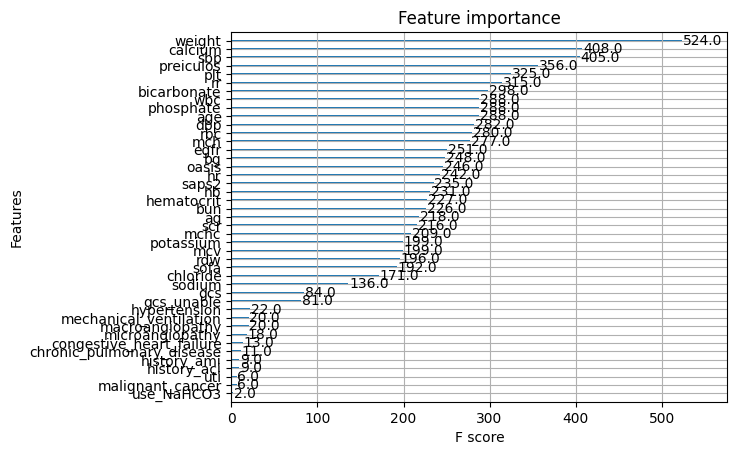

In [16]:
xgb.plot_importance(model)

ImportError: You must install graphviz to plot tree

<Figure size 3000x3000 with 0 Axes>

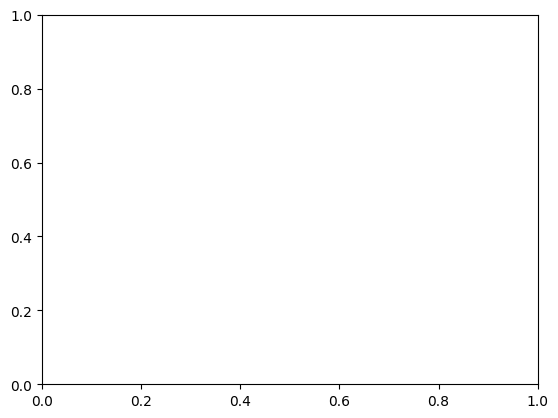

In [17]:
from matplotlib import pyplot as plt


plt.figure(figsize=(30, 30))
xgb.plot_tree(model, num_trees=3)

### Fill missing with knn

In [18]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_val_knn = []
precision_score_list_val_knn = []
recall_score_list_val_knn = []
auc_score_list_val_knn = []
metric_dic_list_val_knn = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeAndFillData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
    y_val = dfVal[labelColumn]  # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_val_knn.append(precision_score(y_test, y_pred))
    recall_score_list_val_knn.append(recall_score(y_test, y_pred))
    auc_score_list_val_knn.append(roc_auc_score(y_test, y_pred_proba))

[0]	validation_0-logloss:0.66734


[1]	validation_0-logloss:0.66500


[2]	validation_0-logloss:0.66293


[3]	validation_0-logloss:0.66044


[4]	validation_0-logloss:0.65783


[5]	validation_0-logloss:0.65521


[6]	validation_0-logloss:0.65274


[7]	validation_0-logloss:0.65004


[8]	validation_0-logloss:0.64791


[9]	validation_0-logloss:0.64626


[10]	validation_0-logloss:0.64381


[11]	validation_0-logloss:0.64146


[12]	validation_0-logloss:0.63957


[13]	validation_0-logloss:0.63779


[14]	validation_0-logloss:0.63607


[15]	validation_0-logloss:0.63372


[16]	validation_0-logloss:0.63152


[17]	validation_0-logloss:0.62922


[18]	validation_0-logloss:0.62756


[19]	validation_0-logloss:0.62613


[20]	validation_0-logloss:0.62451


[21]	validation_0-logloss:0.62296


[22]	validation_0-logloss:0.62061


[23]	validation_0-logloss:0.61899


[24]	validation_0-logloss:0.61693


[25]	validation_0-logloss:0.61516


[26]	validation_0-logloss:0.61352


[27]	validation_0-logloss:0.61223


[28]	validation_0-logloss:0.61053


[29]	validation_0-logloss:0.60880


[30]	validation_0-logloss:0.60774


[31]	validation_0-logloss:0.60626


[32]	validation_0-logloss:0.60490


[33]	validation_0-logloss:0.60371


[34]	validation_0-logloss:0.60206


[35]	validation_0-logloss:0.60054


[36]	validation_0-logloss:0.59880


[37]	validation_0-logloss:0.59725


[38]	validation_0-logloss:0.59610


[39]	validation_0-logloss:0.59445


[40]	validation_0-logloss:0.59317


[41]	validation_0-logloss:0.59226


[42]	validation_0-logloss:0.59117


[43]	validation_0-logloss:0.58987


[44]	validation_0-logloss:0.58838


[45]	validation_0-logloss:0.58692


[46]	validation_0-logloss:0.58591


[47]	validation_0-logloss:0.58441


[48]	validation_0-logloss:0.58362


[49]	validation_0-logloss:0.58250


[50]	validation_0-logloss:0.58137


[51]	validation_0-logloss:0.57987


[52]	validation_0-logloss:0.57900


[53]	validation_0-logloss:0.57756


[54]	validation_0-logloss:0.57630


[55]	validation_0-logloss:0.57493


[56]	validation_0-logloss:0.57411


[57]	validation_0-logloss:0.57318


[58]	validation_0-logloss:0.57248


[59]	validation_0-logloss:0.57159


[60]	validation_0-logloss:0.57039


[61]	validation_0-logloss:0.56976


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:15:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[62]	validation_0-logloss:0.56865


[63]	validation_0-logloss:0.56777


[64]	validation_0-logloss:0.56679


[65]	validation_0-logloss:0.56562


[66]	validation_0-logloss:0.56471


[67]	validation_0-logloss:0.56424


[68]	validation_0-logloss:0.56329

[69]	validation_0-logloss:0.56247


[70]	validation_0-logloss:0.56123

[71]	validation_0-logloss:0.56041


[72]	validation_0-logloss:0.55970


[73]	validation_0-logloss:0.55897

[74]	validation_0-logloss:0.55813


[75]	validation_0-logloss:0.55767


[76]	validation_0-logloss:0.55714

[77]	validation_0-logloss:0.55604

[78]	validation_0-logloss:0.55537


[79]	validation_0-logloss:0.55494


[80]	validation_0-logloss:0.55418


[81]	validation_0-logloss:0.55296


[82]	validation_0-logloss:0.55235


[83]	validation_0-logloss:0.55176


[84]	validation_0-logloss:0.55122


[85]	validation_0-logloss:0.55075


[86]	validation_0-logloss:0.55026


[87]	validation_0-logloss:0.54965


[88]	validation_0-logloss:0.54887

[89]	validation_0-logloss:0.54813

[90]	validation_0-logloss:0.54726


[91]	validation_0-logloss:0.54620

[92]	validation_0-logloss:0.54541


[93]	validation_0-logloss:0.54425


[94]	validation_0-logloss:0.54347


[95]	validation_0-logloss:0.54288


[96]	validation_0-logloss:0.54213


[97]	validation_0-logloss:0.54187


[98]	validation_0-logloss:0.54123


[99]	validation_0-logloss:0.54053


[100]	validation_0-logloss:0.54000


[101]	validation_0-logloss:0.53956


[102]	validation_0-logloss:0.53885

[103]	validation_0-logloss:0.53848


[104]	validation_0-logloss:0.53759


[105]	validation_0-logloss:0.53704


[106]	validation_0-logloss:0.53619


[107]	validation_0-logloss:0.53581


[108]	validation_0-logloss:0.53529


[109]	validation_0-logloss:0.53511


[110]	validation_0-logloss:0.53486


[111]	validation_0-logloss:0.53445


[112]	validation_0-logloss:0.53389


[113]	validation_0-logloss:0.53329


[114]	validation_0-logloss:0.53274

[115]	validation_0-logloss:0.53208


[116]	validation_0-logloss:0.53180


[117]	validation_0-logloss:0.53108


[118]	validation_0-logloss:0.53065


[119]	validation_0-logloss:0.53008


[120]	validation_0-logloss:0.52987


[121]	validation_0-logloss:0.52948


[122]	validation_0-logloss:0.52887


[123]	validation_0-logloss:0.52856


[124]	validation_0-logloss:0.52819


[125]	validation_0-logloss:0.52772


[126]	validation_0-logloss:0.52722


[127]	validation_0-logloss:0.52683


[128]	validation_0-logloss:0.52607


[129]	validation_0-logloss:0.52577


[130]	validation_0-logloss:0.52543


[131]	validation_0-logloss:0.52512


[132]	validation_0-logloss:0.52450


[133]	validation_0-logloss:0.52397


[134]	validation_0-logloss:0.52390


[135]	validation_0-logloss:0.52401


[136]	validation_0-logloss:0.52404


[137]	validation_0-logloss:0.52391


[138]	validation_0-logloss:0.52367


[139]	validation_0-logloss:0.52327


[140]	validation_0-logloss:0.52303


[141]	validation_0-logloss:0.52273


[142]	validation_0-logloss:0.52237


[143]	validation_0-logloss:0.52211


[144]	validation_0-logloss:0.52210


[145]	validation_0-logloss:0.52176


[146]	validation_0-logloss:0.52138


[147]	validation_0-logloss:0.52120

[148]	validation_0-logloss:0.52079


[149]	validation_0-logloss:0.52091


[150]	validation_0-logloss:0.52067


[151]	validation_0-logloss:0.52074


[152]	validation_0-logloss:0.52058


[153]	validation_0-logloss:0.52033


[154]	validation_0-logloss:0.51995


[155]	validation_0-logloss:0.51967


[156]	validation_0-logloss:0.51961


[157]	validation_0-logloss:0.51915


[158]	validation_0-logloss:0.51868


[159]	validation_0-logloss:0.51793


[160]	validation_0-logloss:0.51760


[161]	validation_0-logloss:0.51710


[162]	validation_0-logloss:0.51695


[163]	validation_0-logloss:0.51631


[164]	validation_0-logloss:0.51583


[165]	validation_0-logloss:0.51572


[166]	validation_0-logloss:0.51534


[167]	validation_0-logloss:0.51488


[168]	validation_0-logloss:0.51473


[169]	validation_0-logloss:0.51442


[170]	validation_0-logloss:0.51417


[171]	validation_0-logloss:0.51407


[172]	validation_0-logloss:0.51395


[173]	validation_0-logloss:0.51378


[174]	validation_0-logloss:0.51391


[175]	validation_0-logloss:0.51363


[176]	validation_0-logloss:0.51370

[177]	validation_0-logloss:0.51326


[178]	validation_0-logloss:0.51301


[179]	validation_0-logloss:0.51284


[180]	validation_0-logloss:0.51249


[181]	validation_0-logloss:0.51200


[182]	validation_0-logloss:0.51183


[183]	validation_0-logloss:0.51174


[184]	validation_0-logloss:0.51200


[185]	validation_0-logloss:0.51214


[186]	validation_0-logloss:0.51187


[187]	validation_0-logloss:0.51177


[188]	validation_0-logloss:0.51167

[189]	validation_0-logloss:0.51187


[190]	validation_0-logloss:0.51165


[191]	validation_0-logloss:0.51165


[192]	validation_0-logloss:0.51156


[193]	validation_0-logloss:0.51142


[194]	validation_0-logloss:0.51108


[195]	validation_0-logloss:0.51070


[196]	validation_0-logloss:0.51052


[197]	validation_0-logloss:0.51034


[198]	validation_0-logloss:0.51018


[199]	validation_0-logloss:0.50968

[200]	validation_0-logloss:0.50971


[201]	validation_0-logloss:0.50936


[202]	validation_0-logloss:0.50950


[203]	validation_0-logloss:0.50934


[204]	validation_0-logloss:0.50914


[205]	validation_0-logloss:0.50905


[206]	validation_0-logloss:0.50907


[207]	validation_0-logloss:0.50884


[208]	validation_0-logloss:0.50871


[209]	validation_0-logloss:0.50868


[210]	validation_0-logloss:0.50874


[211]	validation_0-logloss:0.50881


[212]	validation_0-logloss:0.50854


[213]	validation_0-logloss:0.50855


[214]	validation_0-logloss:0.50832


[215]	validation_0-logloss:0.50838


[216]	validation_0-logloss:0.50846


[217]	validation_0-logloss:0.50844


[218]	validation_0-logloss:0.50828


[219]	validation_0-logloss:0.50782


[220]	validation_0-logloss:0.50766


[221]	validation_0-logloss:0.50754


[222]	validation_0-logloss:0.50733

[223]	validation_0-logloss:0.50713


[224]	validation_0-logloss:0.50722


[225]	validation_0-logloss:0.50695

[226]	validation_0-logloss:0.50662

[227]	validation_0-logloss:0.50659


[228]	validation_0-logloss:0.50661

[229]	validation_0-logloss:0.50663

[230]	validation_0-logloss:0.50634


[231]	validation_0-logloss:0.50629

[232]	validation_0-logloss:0.50626


[233]	validation_0-logloss:0.50568


[234]	validation_0-logloss:0.50573


[235]	validation_0-logloss:0.50576


[236]	validation_0-logloss:0.50557

[237]	validation_0-logloss:0.50547


[238]	validation_0-logloss:0.50556

[239]	validation_0-logloss:0.50539


[240]	validation_0-logloss:0.50524


[241]	validation_0-logloss:0.50529

[242]	validation_0-logloss:0.50547


[243]	validation_0-logloss:0.50591


[244]	validation_0-logloss:0.50596


[245]	validation_0-logloss:0.50569


[246]	validation_0-logloss:0.50535


[247]	validation_0-logloss:0.50530


[248]	validation_0-logloss:0.50493


[249]	validation_0-logloss:0.50468


[250]	validation_0-logloss:0.50475


[251]	validation_0-logloss:0.50501


[252]	validation_0-logloss:0.50495


[253]	validation_0-logloss:0.50486


[254]	validation_0-logloss:0.50478


[255]	validation_0-logloss:0.50499


[256]	validation_0-logloss:0.50470


[257]	validation_0-logloss:0.50463


[258]	validation_0-logloss:0.50471

[259]	validation_0-logloss:0.50477


[260]	validation_0-logloss:0.50491


[261]	validation_0-logloss:0.50512


[262]	validation_0-logloss:0.50536


[263]	validation_0-logloss:0.50521

[264]	validation_0-logloss:0.50504


[265]	validation_0-logloss:0.50507


[266]	validation_0-logloss:0.50516


[0]	validation_0-logloss:0.66721


[1]	validation_0-logloss:0.66500


[2]	validation_0-logloss:0.66278


[3]	validation_0-logloss:0.66027


[4]	validation_0-logloss:0.65804


[5]	validation_0-logloss:0.65523


[6]	validation_0-logloss:0.65328


[7]	validation_0-logloss:0.65069


[8]	validation_0-logloss:0.64872


[9]	validation_0-logloss:0.64649


[10]	validation_0-logloss:0.64457


[11]	validation_0-logloss:0.64313


[12]	validation_0-logloss:0.64144


[13]	validation_0-logloss:0.63992


[14]	validation_0-logloss:0.63749


[15]	validation_0-logloss:0.63561


[16]	validation_0-logloss:0.63399


[17]	validation_0-logloss:0.63234


[18]	validation_0-logloss:0.63102


[19]	validation_0-logloss:0.62952


[20]	validation_0-logloss:0.62764


[21]	validation_0-logloss:0.62600


[22]	validation_0-logloss:0.62389


[23]	validation_0-logloss:0.62250


[24]	validation_0-logloss:0.62069


[25]	validation_0-logloss:0.61904


[26]	validation_0-logloss:0.61766


[27]	validation_0-logloss:0.61585


[28]	validation_0-logloss:0.61452


[29]	validation_0-logloss:0.61320


[30]	validation_0-logloss:0.61220


[31]	validation_0-logloss:0.61048


[32]	validation_0-logloss:0.60954


[33]	validation_0-logloss:0.60871


[34]	validation_0-logloss:0.60792


[35]	validation_0-logloss:0.60687


[36]	validation_0-logloss:0.60536


[37]	validation_0-logloss:0.60412


[38]	validation_0-logloss:0.60279


[39]	validation_0-logloss:0.60096


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:15:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[40]	validation_0-logloss:0.59963


[41]	validation_0-logloss:0.59787


[42]	validation_0-logloss:0.59665


[43]	validation_0-logloss:0.59538


[44]	validation_0-logloss:0.59371


[45]	validation_0-logloss:0.59274


[46]	validation_0-logloss:0.59146


[47]	validation_0-logloss:0.59026


[48]	validation_0-logloss:0.58934


[49]	validation_0-logloss:0.58867


[50]	validation_0-logloss:0.58718


[51]	validation_0-logloss:0.58595


[52]	validation_0-logloss:0.58465


[53]	validation_0-logloss:0.58396


[54]	validation_0-logloss:0.58280


[55]	validation_0-logloss:0.58239


[56]	validation_0-logloss:0.58133


[57]	validation_0-logloss:0.58030


[58]	validation_0-logloss:0.57915


[59]	validation_0-logloss:0.57784


[60]	validation_0-logloss:0.57666


[61]	validation_0-logloss:0.57590


[62]	validation_0-logloss:0.57500


[63]	validation_0-logloss:0.57389


[64]	validation_0-logloss:0.57298


[65]	validation_0-logloss:0.57189

[66]	validation_0-logloss:0.57085


[67]	validation_0-logloss:0.56965


[68]	validation_0-logloss:0.56865


[69]	validation_0-logloss:0.56765


[70]	validation_0-logloss:0.56680

[71]	validation_0-logloss:0.56610


[72]	validation_0-logloss:0.56540


[73]	validation_0-logloss:0.56452


[74]	validation_0-logloss:0.56366

[75]	validation_0-logloss:0.56296


[76]	validation_0-logloss:0.56215

[77]	validation_0-logloss:0.56154

[78]	validation_0-logloss:0.56087


[79]	validation_0-logloss:0.56032

[80]	validation_0-logloss:0.55942


[81]	validation_0-logloss:0.55913


[82]	validation_0-logloss:0.55848


[83]	validation_0-logloss:0.55717


[84]	validation_0-logloss:0.55640


[85]	validation_0-logloss:0.55584

[86]	validation_0-logloss:0.55511


[87]	validation_0-logloss:0.55397


[88]	validation_0-logloss:0.55355


[89]	validation_0-logloss:0.55323


[90]	validation_0-logloss:0.55250


[91]	validation_0-logloss:0.55186


[92]	validation_0-logloss:0.55089


[93]	validation_0-logloss:0.55053


[94]	validation_0-logloss:0.54974


[95]	validation_0-logloss:0.54907


[96]	validation_0-logloss:0.54867


[97]	validation_0-logloss:0.54792


[98]	validation_0-logloss:0.54725


[99]	validation_0-logloss:0.54648


[100]	validation_0-logloss:0.54591


[101]	validation_0-logloss:0.54508


[102]	validation_0-logloss:0.54503


[103]	validation_0-logloss:0.54422


[104]	validation_0-logloss:0.54357


[105]	validation_0-logloss:0.54271


[106]	validation_0-logloss:0.54209


[107]	validation_0-logloss:0.54153


[108]	validation_0-logloss:0.54111

[109]	validation_0-logloss:0.54066


[110]	validation_0-logloss:0.54023


[111]	validation_0-logloss:0.54006

[112]	validation_0-logloss:0.53950


[113]	validation_0-logloss:0.53889


[114]	validation_0-logloss:0.53800


[115]	validation_0-logloss:0.53723


[116]	validation_0-logloss:0.53659


[117]	validation_0-logloss:0.53617


[118]	validation_0-logloss:0.53559


[119]	validation_0-logloss:0.53532


[120]	validation_0-logloss:0.53449


[121]	validation_0-logloss:0.53403


[122]	validation_0-logloss:0.53352


[123]	validation_0-logloss:0.53318


[124]	validation_0-logloss:0.53223


[125]	validation_0-logloss:0.53160


[126]	validation_0-logloss:0.53074


[127]	validation_0-logloss:0.53034


[128]	validation_0-logloss:0.52986


[129]	validation_0-logloss:0.52924


[130]	validation_0-logloss:0.52873


[131]	validation_0-logloss:0.52831


[132]	validation_0-logloss:0.52755


[133]	validation_0-logloss:0.52700

[134]	validation_0-logloss:0.52680


[135]	validation_0-logloss:0.52632


[136]	validation_0-logloss:0.52599


[137]	validation_0-logloss:0.52571


[138]	validation_0-logloss:0.52542

[139]	validation_0-logloss:0.52508


[140]	validation_0-logloss:0.52469


[141]	validation_0-logloss:0.52423

[142]	validation_0-logloss:0.52363


[143]	validation_0-logloss:0.52317


[144]	validation_0-logloss:0.52295


[145]	validation_0-logloss:0.52261


[146]	validation_0-logloss:0.52222


[147]	validation_0-logloss:0.52207


[148]	validation_0-logloss:0.52126


[149]	validation_0-logloss:0.52063


[150]	validation_0-logloss:0.52010


[151]	validation_0-logloss:0.51980


[152]	validation_0-logloss:0.51939


[153]	validation_0-logloss:0.51916


[154]	validation_0-logloss:0.51916


[155]	validation_0-logloss:0.51872


[156]	validation_0-logloss:0.51865


[157]	validation_0-logloss:0.51817


[158]	validation_0-logloss:0.51768


[159]	validation_0-logloss:0.51728


[160]	validation_0-logloss:0.51676


[161]	validation_0-logloss:0.51642


[162]	validation_0-logloss:0.51625


[163]	validation_0-logloss:0.51656


[164]	validation_0-logloss:0.51611


[165]	validation_0-logloss:0.51565


[166]	validation_0-logloss:0.51513


[167]	validation_0-logloss:0.51467


[168]	validation_0-logloss:0.51395

[169]	validation_0-logloss:0.51385


[170]	validation_0-logloss:0.51395


[171]	validation_0-logloss:0.51383


[172]	validation_0-logloss:0.51369


[173]	validation_0-logloss:0.51337


[174]	validation_0-logloss:0.51317


[175]	validation_0-logloss:0.51291


[176]	validation_0-logloss:0.51258


[177]	validation_0-logloss:0.51230


[178]	validation_0-logloss:0.51210


[179]	validation_0-logloss:0.51173


[180]	validation_0-logloss:0.51154


[181]	validation_0-logloss:0.51123


[182]	validation_0-logloss:0.51063


[183]	validation_0-logloss:0.51063


[184]	validation_0-logloss:0.51033


[185]	validation_0-logloss:0.51021


[186]	validation_0-logloss:0.50999


[187]	validation_0-logloss:0.51017


[188]	validation_0-logloss:0.51012


[189]	validation_0-logloss:0.50986


[190]	validation_0-logloss:0.51003


[191]	validation_0-logloss:0.50997


[192]	validation_0-logloss:0.50971


[193]	validation_0-logloss:0.50936


[194]	validation_0-logloss:0.50955


[195]	validation_0-logloss:0.50931


[196]	validation_0-logloss:0.50916


[197]	validation_0-logloss:0.50888


[198]	validation_0-logloss:0.50872


[199]	validation_0-logloss:0.50859


[200]	validation_0-logloss:0.50850

[201]	validation_0-logloss:0.50863

[202]	validation_0-logloss:0.50854


[203]	validation_0-logloss:0.50840

[204]	validation_0-logloss:0.50800


[205]	validation_0-logloss:0.50800


[206]	validation_0-logloss:0.50774


[207]	validation_0-logloss:0.50749


[208]	validation_0-logloss:0.50735


[209]	validation_0-logloss:0.50738


[210]	validation_0-logloss:0.50723


[211]	validation_0-logloss:0.50673


[212]	validation_0-logloss:0.50677


[213]	validation_0-logloss:0.50665


[214]	validation_0-logloss:0.50651


[215]	validation_0-logloss:0.50625


[216]	validation_0-logloss:0.50574


[217]	validation_0-logloss:0.50530


[218]	validation_0-logloss:0.50500


[219]	validation_0-logloss:0.50470


[220]	validation_0-logloss:0.50433


[221]	validation_0-logloss:0.50426


[222]	validation_0-logloss:0.50378


[223]	validation_0-logloss:0.50346


[224]	validation_0-logloss:0.50345


[225]	validation_0-logloss:0.50318


[226]	validation_0-logloss:0.50316


[227]	validation_0-logloss:0.50326


[228]	validation_0-logloss:0.50297


[229]	validation_0-logloss:0.50284


[230]	validation_0-logloss:0.50268


[231]	validation_0-logloss:0.50244


[232]	validation_0-logloss:0.50205


[233]	validation_0-logloss:0.50202


[234]	validation_0-logloss:0.50211


[235]	validation_0-logloss:0.50221


[236]	validation_0-logloss:0.50192


[237]	validation_0-logloss:0.50171


[238]	validation_0-logloss:0.50166


[239]	validation_0-logloss:0.50149


[240]	validation_0-logloss:0.50141


[241]	validation_0-logloss:0.50146


[242]	validation_0-logloss:0.50125


[243]	validation_0-logloss:0.50110


[244]	validation_0-logloss:0.50099


[245]	validation_0-logloss:0.50088


[246]	validation_0-logloss:0.50067


[247]	validation_0-logloss:0.50051


[248]	validation_0-logloss:0.50046


[249]	validation_0-logloss:0.50023


[250]	validation_0-logloss:0.50025


[251]	validation_0-logloss:0.50022

[252]	validation_0-logloss:0.50001


[253]	validation_0-logloss:0.50022


[254]	validation_0-logloss:0.50014


[255]	validation_0-logloss:0.49985


[256]	validation_0-logloss:0.49998


[257]	validation_0-logloss:0.50019


[258]	validation_0-logloss:0.50007


[259]	validation_0-logloss:0.49983


[260]	validation_0-logloss:0.49983


[261]	validation_0-logloss:0.49951


[262]	validation_0-logloss:0.49977


[263]	validation_0-logloss:0.49951


[264]	validation_0-logloss:0.49944

[265]	validation_0-logloss:0.49944


[266]	validation_0-logloss:0.49927


[267]	validation_0-logloss:0.49921


[268]	validation_0-logloss:0.49914


[269]	validation_0-logloss:0.49903


[270]	validation_0-logloss:0.49899


[271]	validation_0-logloss:0.49849


[272]	validation_0-logloss:0.49870


[273]	validation_0-logloss:0.49873


[274]	validation_0-logloss:0.49864


[275]	validation_0-logloss:0.49883


[276]	validation_0-logloss:0.49893


[277]	validation_0-logloss:0.49895


[278]	validation_0-logloss:0.49884


[279]	validation_0-logloss:0.49882


[280]	validation_0-logloss:0.49848


[281]	validation_0-logloss:0.49884


[282]	validation_0-logloss:0.49890


[283]	validation_0-logloss:0.49904


[284]	validation_0-logloss:0.49901


[285]	validation_0-logloss:0.49893


[286]	validation_0-logloss:0.49904


[287]	validation_0-logloss:0.49919


[288]	validation_0-logloss:0.49913


[289]	validation_0-logloss:0.49922


[0]	validation_0-logloss:0.66805


[1]	validation_0-logloss:0.66609


[2]	validation_0-logloss:0.66372


[3]	validation_0-logloss:0.66133


[4]	validation_0-logloss:0.65960


[5]	validation_0-logloss:0.65758


[6]	validation_0-logloss:0.65587


[7]	validation_0-logloss:0.65443


[8]	validation_0-logloss:0.65210


[9]	validation_0-logloss:0.65022


[10]	validation_0-logloss:0.64843


[11]	validation_0-logloss:0.64629


[12]	validation_0-logloss:0.64495


[13]	validation_0-logloss:0.64325


[14]	validation_0-logloss:0.64053


[15]	validation_0-logloss:0.63854


[16]	validation_0-logloss:0.63720


[17]	validation_0-logloss:0.63548


[18]	validation_0-logloss:0.63414


[19]	validation_0-logloss:0.63251


[20]	validation_0-logloss:0.63112


[21]	validation_0-logloss:0.63026


[22]	validation_0-logloss:0.62820


[23]	validation_0-logloss:0.62648


[24]	validation_0-logloss:0.62516


[25]	validation_0-logloss:0.62343


[26]	validation_0-logloss:0.62179


[27]	validation_0-logloss:0.62052


[28]	validation_0-logloss:0.61968


[29]	validation_0-logloss:0.61766


[30]	validation_0-logloss:0.61591


[31]	validation_0-logloss:0.61516


[32]	validation_0-logloss:0.61352


[33]	validation_0-logloss:0.61220


[34]	validation_0-logloss:0.61110


[35]	validation_0-logloss:0.60954


[36]	validation_0-logloss:0.60852


[37]	validation_0-logloss:0.60796


[38]	validation_0-logloss:0.60704


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:15:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[39]	validation_0-logloss:0.60610


[40]	validation_0-logloss:0.60528


[41]	validation_0-logloss:0.60425


[42]	validation_0-logloss:0.60342


[43]	validation_0-logloss:0.60269


[44]	validation_0-logloss:0.60175


[45]	validation_0-logloss:0.60082


[46]	validation_0-logloss:0.60014


[47]	validation_0-logloss:0.59900


[48]	validation_0-logloss:0.59819


[49]	validation_0-logloss:0.59710


[50]	validation_0-logloss:0.59598


[51]	validation_0-logloss:0.59500

[52]	validation_0-logloss:0.59414


[53]	validation_0-logloss:0.59305


[54]	validation_0-logloss:0.59228


[55]	validation_0-logloss:0.59149


[56]	validation_0-logloss:0.59048


[57]	validation_0-logloss:0.58989


[58]	validation_0-logloss:0.58889


[59]	validation_0-logloss:0.58830


[60]	validation_0-logloss:0.58747


[61]	validation_0-logloss:0.58659


[62]	validation_0-logloss:0.58562


[63]	validation_0-logloss:0.58507


[64]	validation_0-logloss:0.58432


[65]	validation_0-logloss:0.58328


[66]	validation_0-logloss:0.58257


[67]	validation_0-logloss:0.58129


[68]	validation_0-logloss:0.58084


[69]	validation_0-logloss:0.57984


[70]	validation_0-logloss:0.57912


[71]	validation_0-logloss:0.57867


[72]	validation_0-logloss:0.57744


[73]	validation_0-logloss:0.57618


[74]	validation_0-logloss:0.57560


[75]	validation_0-logloss:0.57512


[76]	validation_0-logloss:0.57460

[77]	validation_0-logloss:0.57410


[78]	validation_0-logloss:0.57323


[79]	validation_0-logloss:0.57281


[80]	validation_0-logloss:0.57268


[81]	validation_0-logloss:0.57212


[82]	validation_0-logloss:0.57152


[83]	validation_0-logloss:0.57089


[84]	validation_0-logloss:0.56960


[85]	validation_0-logloss:0.56890


[86]	validation_0-logloss:0.56856


[87]	validation_0-logloss:0.56759


[88]	validation_0-logloss:0.56721


[89]	validation_0-logloss:0.56677


[90]	validation_0-logloss:0.56641


[91]	validation_0-logloss:0.56580


[92]	validation_0-logloss:0.56529


[93]	validation_0-logloss:0.56475


[94]	validation_0-logloss:0.56433


[95]	validation_0-logloss:0.56442


[96]	validation_0-logloss:0.56453


[97]	validation_0-logloss:0.56377


[98]	validation_0-logloss:0.56333


[99]	validation_0-logloss:0.56294


[100]	validation_0-logloss:0.56292


[101]	validation_0-logloss:0.56272


[102]	validation_0-logloss:0.56230

[103]	validation_0-logloss:0.56164


[104]	validation_0-logloss:0.56085


[105]	validation_0-logloss:0.56068


[106]	validation_0-logloss:0.56034


[107]	validation_0-logloss:0.55995


[108]	validation_0-logloss:0.55954


[109]	validation_0-logloss:0.55935

[110]	validation_0-logloss:0.55897


[111]	validation_0-logloss:0.55860


[112]	validation_0-logloss:0.55808


[113]	validation_0-logloss:0.55783


[114]	validation_0-logloss:0.55760

[115]	validation_0-logloss:0.55707


[116]	validation_0-logloss:0.55655


[117]	validation_0-logloss:0.55580


[118]	validation_0-logloss:0.55562


[119]	validation_0-logloss:0.55534


[120]	validation_0-logloss:0.55470


[121]	validation_0-logloss:0.55459


[122]	validation_0-logloss:0.55375


[123]	validation_0-logloss:0.55338


[124]	validation_0-logloss:0.55282


[125]	validation_0-logloss:0.55250


[126]	validation_0-logloss:0.55222


[127]	validation_0-logloss:0.55191


[128]	validation_0-logloss:0.55123


[129]	validation_0-logloss:0.55113


[130]	validation_0-logloss:0.55077


[131]	validation_0-logloss:0.55048


[132]	validation_0-logloss:0.55033


[133]	validation_0-logloss:0.54989


[134]	validation_0-logloss:0.54958


[135]	validation_0-logloss:0.54946


[136]	validation_0-logloss:0.54929


[137]	validation_0-logloss:0.54891


[138]	validation_0-logloss:0.54816


[139]	validation_0-logloss:0.54780


[140]	validation_0-logloss:0.54742


[141]	validation_0-logloss:0.54706


[142]	validation_0-logloss:0.54669


[143]	validation_0-logloss:0.54675


[144]	validation_0-logloss:0.54668


[145]	validation_0-logloss:0.54666


[146]	validation_0-logloss:0.54618


[147]	validation_0-logloss:0.54551


[148]	validation_0-logloss:0.54510


[149]	validation_0-logloss:0.54504

[150]	validation_0-logloss:0.54463


[151]	validation_0-logloss:0.54441

[152]	validation_0-logloss:0.54432


[153]	validation_0-logloss:0.54449


[154]	validation_0-logloss:0.54431


[155]	validation_0-logloss:0.54418


[156]	validation_0-logloss:0.54417


[157]	validation_0-logloss:0.54395

[158]	validation_0-logloss:0.54381


[159]	validation_0-logloss:0.54365


[160]	validation_0-logloss:0.54338


[161]	validation_0-logloss:0.54355


[162]	validation_0-logloss:0.54303


[163]	validation_0-logloss:0.54271


[164]	validation_0-logloss:0.54252


[165]	validation_0-logloss:0.54248


[166]	validation_0-logloss:0.54240


[167]	validation_0-logloss:0.54202


[168]	validation_0-logloss:0.54181


[169]	validation_0-logloss:0.54157


[170]	validation_0-logloss:0.54140


[171]	validation_0-logloss:0.54092


[172]	validation_0-logloss:0.54052


[173]	validation_0-logloss:0.54017

[174]	validation_0-logloss:0.54025


[175]	validation_0-logloss:0.53938


[176]	validation_0-logloss:0.53930


[177]	validation_0-logloss:0.53930


[178]	validation_0-logloss:0.53958


[179]	validation_0-logloss:0.53959


[180]	validation_0-logloss:0.53899

[181]	validation_0-logloss:0.53906

[182]	validation_0-logloss:0.53896


[183]	validation_0-logloss:0.53873


[184]	validation_0-logloss:0.53885

[185]	validation_0-logloss:0.53864


[186]	validation_0-logloss:0.53837


[187]	validation_0-logloss:0.53815


[188]	validation_0-logloss:0.53752


[189]	validation_0-logloss:0.53751


[190]	validation_0-logloss:0.53774


[191]	validation_0-logloss:0.53770

[192]	validation_0-logloss:0.53729


[193]	validation_0-logloss:0.53708


[194]	validation_0-logloss:0.53691


[195]	validation_0-logloss:0.53698


[196]	validation_0-logloss:0.53678


[197]	validation_0-logloss:0.53669


[198]	validation_0-logloss:0.53667


[199]	validation_0-logloss:0.53648


[200]	validation_0-logloss:0.53630


[201]	validation_0-logloss:0.53618


[202]	validation_0-logloss:0.53586


[203]	validation_0-logloss:0.53569


[204]	validation_0-logloss:0.53536


[205]	validation_0-logloss:0.53587


[206]	validation_0-logloss:0.53545


[207]	validation_0-logloss:0.53533


[208]	validation_0-logloss:0.53499


[209]	validation_0-logloss:0.53488


[210]	validation_0-logloss:0.53468


[211]	validation_0-logloss:0.53452


[212]	validation_0-logloss:0.53450


[213]	validation_0-logloss:0.53443


[214]	validation_0-logloss:0.53463


[215]	validation_0-logloss:0.53467


[216]	validation_0-logloss:0.53448


[217]	validation_0-logloss:0.53457


[218]	validation_0-logloss:0.53422


[219]	validation_0-logloss:0.53364


[220]	validation_0-logloss:0.53353


[221]	validation_0-logloss:0.53344


[222]	validation_0-logloss:0.53331


[223]	validation_0-logloss:0.53327


[224]	validation_0-logloss:0.53304


[225]	validation_0-logloss:0.53293


[226]	validation_0-logloss:0.53308


[227]	validation_0-logloss:0.53297


[228]	validation_0-logloss:0.53300


[229]	validation_0-logloss:0.53322


[230]	validation_0-logloss:0.53330


[231]	validation_0-logloss:0.53313


[232]	validation_0-logloss:0.53306


[233]	validation_0-logloss:0.53333


[234]	validation_0-logloss:0.53335


[0]	validation_0-logloss:0.66778


[1]	validation_0-logloss:0.66567


[2]	validation_0-logloss:0.66275


[3]	validation_0-logloss:0.66109


[4]	validation_0-logloss:0.65912


[5]	validation_0-logloss:0.65711


[6]	validation_0-logloss:0.65478


[7]	validation_0-logloss:0.65240


[8]	validation_0-logloss:0.65042


[9]	validation_0-logloss:0.64925


[10]	validation_0-logloss:0.64815


[11]	validation_0-logloss:0.64705


[12]	validation_0-logloss:0.64520


[13]	validation_0-logloss:0.64365


[14]	validation_0-logloss:0.64184


[15]	validation_0-logloss:0.64000


[16]	validation_0-logloss:0.63856


[17]	validation_0-logloss:0.63651


[18]	validation_0-logloss:0.63537


[19]	validation_0-logloss:0.63420


[20]	validation_0-logloss:0.63220


[21]	validation_0-logloss:0.63066


[22]	validation_0-logloss:0.62880


[23]	validation_0-logloss:0.62728


[24]	validation_0-logloss:0.62561


[25]	validation_0-logloss:0.62394


[26]	validation_0-logloss:0.62224


[27]	validation_0-logloss:0.62063


[28]	validation_0-logloss:0.61957


[29]	validation_0-logloss:0.61830


[30]	validation_0-logloss:0.61687


[31]	validation_0-logloss:0.61547


[32]	validation_0-logloss:0.61388


[33]	validation_0-logloss:0.61251


[34]	validation_0-logloss:0.61068


[35]	validation_0-logloss:0.60931


[36]	validation_0-logloss:0.60811


[37]	validation_0-logloss:0.60687


[38]	validation_0-logloss:0.60575


[39]	validation_0-logloss:0.60457


[40]	validation_0-logloss:0.60321


[41]	validation_0-logloss:0.60179


[42]	validation_0-logloss:0.60129


[43]	validation_0-logloss:0.60032


[44]	validation_0-logloss:0.59969


[45]	validation_0-logloss:0.59853


[46]	validation_0-logloss:0.59720


[47]	validation_0-logloss:0.59576


[48]	validation_0-logloss:0.59407


[49]	validation_0-logloss:0.59336


[50]	validation_0-logloss:0.59288


[51]	validation_0-logloss:0.59211


[52]	validation_0-logloss:0.59147


[53]	validation_0-logloss:0.59025


[54]	validation_0-logloss:0.58954


[55]	validation_0-logloss:0.58810


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:16:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[56]	validation_0-logloss:0.58754


[57]	validation_0-logloss:0.58627


[58]	validation_0-logloss:0.58507


[59]	validation_0-logloss:0.58422


[60]	validation_0-logloss:0.58337


[61]	validation_0-logloss:0.58255


[62]	validation_0-logloss:0.58149

[63]	validation_0-logloss:0.58088


[64]	validation_0-logloss:0.58010


[65]	validation_0-logloss:0.57940


[66]	validation_0-logloss:0.57872


[67]	validation_0-logloss:0.57788


[68]	validation_0-logloss:0.57691


[69]	validation_0-logloss:0.57636


[70]	validation_0-logloss:0.57569


[71]	validation_0-logloss:0.57472


[72]	validation_0-logloss:0.57379


[73]	validation_0-logloss:0.57293


[74]	validation_0-logloss:0.57212


[75]	validation_0-logloss:0.57110


[76]	validation_0-logloss:0.57119


[77]	validation_0-logloss:0.57069


[78]	validation_0-logloss:0.56954


[79]	validation_0-logloss:0.56913


[80]	validation_0-logloss:0.56837


[81]	validation_0-logloss:0.56806


[82]	validation_0-logloss:0.56729


[83]	validation_0-logloss:0.56712


[84]	validation_0-logloss:0.56680


[85]	validation_0-logloss:0.56580


[86]	validation_0-logloss:0.56501


[87]	validation_0-logloss:0.56464

[88]	validation_0-logloss:0.56384

[89]	validation_0-logloss:0.56301


[90]	validation_0-logloss:0.56270


[91]	validation_0-logloss:0.56215


[92]	validation_0-logloss:0.56108


[93]	validation_0-logloss:0.56049


[94]	validation_0-logloss:0.55985


[95]	validation_0-logloss:0.55923


[96]	validation_0-logloss:0.55842


[97]	validation_0-logloss:0.55778


[98]	validation_0-logloss:0.55721


[99]	validation_0-logloss:0.55674


[100]	validation_0-logloss:0.55648


[101]	validation_0-logloss:0.55560


[102]	validation_0-logloss:0.55468


[103]	validation_0-logloss:0.55451


[104]	validation_0-logloss:0.55393


[105]	validation_0-logloss:0.55374


[106]	validation_0-logloss:0.55340


[107]	validation_0-logloss:0.55270


[108]	validation_0-logloss:0.55197


[109]	validation_0-logloss:0.55147


[110]	validation_0-logloss:0.55086


[111]	validation_0-logloss:0.55029


[112]	validation_0-logloss:0.54964


[113]	validation_0-logloss:0.54917


[114]	validation_0-logloss:0.54896


[115]	validation_0-logloss:0.54882


[116]	validation_0-logloss:0.54829


[117]	validation_0-logloss:0.54728


[118]	validation_0-logloss:0.54686


[119]	validation_0-logloss:0.54659


[120]	validation_0-logloss:0.54607


[121]	validation_0-logloss:0.54602


[122]	validation_0-logloss:0.54550


[123]	validation_0-logloss:0.54541


[124]	validation_0-logloss:0.54511

[125]	validation_0-logloss:0.54484


[126]	validation_0-logloss:0.54445


[127]	validation_0-logloss:0.54414


[128]	validation_0-logloss:0.54397


[129]	validation_0-logloss:0.54397


[130]	validation_0-logloss:0.54363


[131]	validation_0-logloss:0.54345


[132]	validation_0-logloss:0.54346


[133]	validation_0-logloss:0.54302


[134]	validation_0-logloss:0.54271


[135]	validation_0-logloss:0.54233


[136]	validation_0-logloss:0.54217


[137]	validation_0-logloss:0.54183


[138]	validation_0-logloss:0.54176


[139]	validation_0-logloss:0.54151


[140]	validation_0-logloss:0.54120


[141]	validation_0-logloss:0.54084


[142]	validation_0-logloss:0.54097


[143]	validation_0-logloss:0.54051


[144]	validation_0-logloss:0.54005


[145]	validation_0-logloss:0.53973


[146]	validation_0-logloss:0.53911


[147]	validation_0-logloss:0.53845


[148]	validation_0-logloss:0.53783


[149]	validation_0-logloss:0.53736


[150]	validation_0-logloss:0.53693


[151]	validation_0-logloss:0.53680


[152]	validation_0-logloss:0.53637


[153]	validation_0-logloss:0.53601


[154]	validation_0-logloss:0.53557


[155]	validation_0-logloss:0.53519


[156]	validation_0-logloss:0.53491


[157]	validation_0-logloss:0.53449


[158]	validation_0-logloss:0.53391


[159]	validation_0-logloss:0.53340


[160]	validation_0-logloss:0.53338


[161]	validation_0-logloss:0.53295


[162]	validation_0-logloss:0.53332


[163]	validation_0-logloss:0.53278

[164]	validation_0-logloss:0.53232

[165]	validation_0-logloss:0.53258


[166]	validation_0-logloss:0.53251


[167]	validation_0-logloss:0.53213


[168]	validation_0-logloss:0.53200


[169]	validation_0-logloss:0.53236


[170]	validation_0-logloss:0.53199


[171]	validation_0-logloss:0.53204


[172]	validation_0-logloss:0.53206


[173]	validation_0-logloss:0.53190


[174]	validation_0-logloss:0.53151


[175]	validation_0-logloss:0.53157

[176]	validation_0-logloss:0.53124


[177]	validation_0-logloss:0.53098


[178]	validation_0-logloss:0.53073


[179]	validation_0-logloss:0.53059


[180]	validation_0-logloss:0.53044


[181]	validation_0-logloss:0.52999


[182]	validation_0-logloss:0.52945


[183]	validation_0-logloss:0.52925


[184]	validation_0-logloss:0.52890


[185]	validation_0-logloss:0.52900

[186]	validation_0-logloss:0.52885

[187]	validation_0-logloss:0.52863


[188]	validation_0-logloss:0.52843

[189]	validation_0-logloss:0.52843


[190]	validation_0-logloss:0.52836

[191]	validation_0-logloss:0.52835


[192]	validation_0-logloss:0.52790


[193]	validation_0-logloss:0.52824


[194]	validation_0-logloss:0.52816


[195]	validation_0-logloss:0.52788


[196]	validation_0-logloss:0.52781


[197]	validation_0-logloss:0.52778


[198]	validation_0-logloss:0.52774


[199]	validation_0-logloss:0.52765


[200]	validation_0-logloss:0.52764


[201]	validation_0-logloss:0.52776


[202]	validation_0-logloss:0.52728


[203]	validation_0-logloss:0.52729


[204]	validation_0-logloss:0.52751


[205]	validation_0-logloss:0.52728


[206]	validation_0-logloss:0.52743


[207]	validation_0-logloss:0.52726


[208]	validation_0-logloss:0.52749


[209]	validation_0-logloss:0.52754


[210]	validation_0-logloss:0.52727


[211]	validation_0-logloss:0.52692


[212]	validation_0-logloss:0.52671


[213]	validation_0-logloss:0.52645


[214]	validation_0-logloss:0.52665


[215]	validation_0-logloss:0.52642


[216]	validation_0-logloss:0.52665


[217]	validation_0-logloss:0.52620


[218]	validation_0-logloss:0.52626


[219]	validation_0-logloss:0.52634


[220]	validation_0-logloss:0.52623


[221]	validation_0-logloss:0.52586


[222]	validation_0-logloss:0.52612

[223]	validation_0-logloss:0.52583


[224]	validation_0-logloss:0.52563


[225]	validation_0-logloss:0.52551


[226]	validation_0-logloss:0.52520


[227]	validation_0-logloss:0.52504


[228]	validation_0-logloss:0.52473


[229]	validation_0-logloss:0.52452


[230]	validation_0-logloss:0.52470


[231]	validation_0-logloss:0.52428


[232]	validation_0-logloss:0.52448


[233]	validation_0-logloss:0.52432


[234]	validation_0-logloss:0.52388


[235]	validation_0-logloss:0.52405


[236]	validation_0-logloss:0.52386


[237]	validation_0-logloss:0.52366


[238]	validation_0-logloss:0.52340


[239]	validation_0-logloss:0.52339

[240]	validation_0-logloss:0.52311


[241]	validation_0-logloss:0.52297


[242]	validation_0-logloss:0.52265


[243]	validation_0-logloss:0.52281


[244]	validation_0-logloss:0.52267


[245]	validation_0-logloss:0.52260


[246]	validation_0-logloss:0.52237


[247]	validation_0-logloss:0.52238


[248]	validation_0-logloss:0.52232


[249]	validation_0-logloss:0.52228


[250]	validation_0-logloss:0.52196


[251]	validation_0-logloss:0.52212


[252]	validation_0-logloss:0.52233


[253]	validation_0-logloss:0.52266


[254]	validation_0-logloss:0.52274


[255]	validation_0-logloss:0.52290


[256]	validation_0-logloss:0.52265


[257]	validation_0-logloss:0.52264


[258]	validation_0-logloss:0.52272


[259]	validation_0-logloss:0.52257


[0]	validation_0-logloss:0.66775


[1]	validation_0-logloss:0.66519


[2]	validation_0-logloss:0.66271


[3]	validation_0-logloss:0.66080


[4]	validation_0-logloss:0.65915


[5]	validation_0-logloss:0.65734


[6]	validation_0-logloss:0.65564


[7]	validation_0-logloss:0.65356


[8]	validation_0-logloss:0.65192


[9]	validation_0-logloss:0.65049


[10]	validation_0-logloss:0.64834


[11]	validation_0-logloss:0.64711


[12]	validation_0-logloss:0.64585


[13]	validation_0-logloss:0.64414


[14]	validation_0-logloss:0.64206


[15]	validation_0-logloss:0.64062


[16]	validation_0-logloss:0.63886


[17]	validation_0-logloss:0.63664


[18]	validation_0-logloss:0.63546


[19]	validation_0-logloss:0.63370


[20]	validation_0-logloss:0.63221


[21]	validation_0-logloss:0.63061


[22]	validation_0-logloss:0.62807


[23]	validation_0-logloss:0.62665


[24]	validation_0-logloss:0.62553


[25]	validation_0-logloss:0.62420


[26]	validation_0-logloss:0.62288


[27]	validation_0-logloss:0.62146


[28]	validation_0-logloss:0.61986


[29]	validation_0-logloss:0.61798


[30]	validation_0-logloss:0.61641


[31]	validation_0-logloss:0.61453


[32]	validation_0-logloss:0.61336


[33]	validation_0-logloss:0.61151


[34]	validation_0-logloss:0.60999


[35]	validation_0-logloss:0.60874


[36]	validation_0-logloss:0.60749


[37]	validation_0-logloss:0.60708


[38]	validation_0-logloss:0.60636


[39]	validation_0-logloss:0.60486


[40]	validation_0-logloss:0.60349


[41]	validation_0-logloss:0.60302


[42]	validation_0-logloss:0.60185


[43]	validation_0-logloss:0.60093


[44]	validation_0-logloss:0.60003


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:16:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[45]	validation_0-logloss:0.59909


[46]	validation_0-logloss:0.59791


[47]	validation_0-logloss:0.59696


[48]	validation_0-logloss:0.59611


[49]	validation_0-logloss:0.59455


[50]	validation_0-logloss:0.59385


[51]	validation_0-logloss:0.59291


[52]	validation_0-logloss:0.59244


[53]	validation_0-logloss:0.59137


[54]	validation_0-logloss:0.59033


[55]	validation_0-logloss:0.58954


[56]	validation_0-logloss:0.58859


[57]	validation_0-logloss:0.58712


[58]	validation_0-logloss:0.58656


[59]	validation_0-logloss:0.58613


[60]	validation_0-logloss:0.58503


[61]	validation_0-logloss:0.58382


[62]	validation_0-logloss:0.58297


[63]	validation_0-logloss:0.58185


[64]	validation_0-logloss:0.58094


[65]	validation_0-logloss:0.57994


[66]	validation_0-logloss:0.57930


[67]	validation_0-logloss:0.57855


[68]	validation_0-logloss:0.57750

[69]	validation_0-logloss:0.57736


[70]	validation_0-logloss:0.57675


[71]	validation_0-logloss:0.57628

[72]	validation_0-logloss:0.57560


[73]	validation_0-logloss:0.57484


[74]	validation_0-logloss:0.57376


[75]	validation_0-logloss:0.57280


[76]	validation_0-logloss:0.57252

[77]	validation_0-logloss:0.57201


[78]	validation_0-logloss:0.57135


[79]	validation_0-logloss:0.57041


[80]	validation_0-logloss:0.57011


[81]	validation_0-logloss:0.56987


[82]	validation_0-logloss:0.56953


[83]	validation_0-logloss:0.56879


[84]	validation_0-logloss:0.56809


[85]	validation_0-logloss:0.56789


[86]	validation_0-logloss:0.56716


[87]	validation_0-logloss:0.56647


[88]	validation_0-logloss:0.56617


[89]	validation_0-logloss:0.56524


[90]	validation_0-logloss:0.56488


[91]	validation_0-logloss:0.56402


[92]	validation_0-logloss:0.56322

[93]	validation_0-logloss:0.56254


[94]	validation_0-logloss:0.56238


[95]	validation_0-logloss:0.56243


[96]	validation_0-logloss:0.56154


[97]	validation_0-logloss:0.56091


[98]	validation_0-logloss:0.56051


[99]	validation_0-logloss:0.55989


[100]	validation_0-logloss:0.55911


[101]	validation_0-logloss:0.55844


[102]	validation_0-logloss:0.55875


[103]	validation_0-logloss:0.55837


[104]	validation_0-logloss:0.55784


[105]	validation_0-logloss:0.55786


[106]	validation_0-logloss:0.55780


[107]	validation_0-logloss:0.55737


[108]	validation_0-logloss:0.55635


[109]	validation_0-logloss:0.55597


[110]	validation_0-logloss:0.55540


[111]	validation_0-logloss:0.55462


[112]	validation_0-logloss:0.55396


[113]	validation_0-logloss:0.55352


[114]	validation_0-logloss:0.55293


[115]	validation_0-logloss:0.55301


[116]	validation_0-logloss:0.55263


[117]	validation_0-logloss:0.55234


[118]	validation_0-logloss:0.55193


[119]	validation_0-logloss:0.55147


[120]	validation_0-logloss:0.55163


[121]	validation_0-logloss:0.55124


[122]	validation_0-logloss:0.55083


[123]	validation_0-logloss:0.55042


[124]	validation_0-logloss:0.54969

[125]	validation_0-logloss:0.54937


[126]	validation_0-logloss:0.54910


[127]	validation_0-logloss:0.54881


[128]	validation_0-logloss:0.54821


[129]	validation_0-logloss:0.54821


[130]	validation_0-logloss:0.54783


[131]	validation_0-logloss:0.54769


[132]	validation_0-logloss:0.54715


[133]	validation_0-logloss:0.54682


[134]	validation_0-logloss:0.54633


[135]	validation_0-logloss:0.54591


[136]	validation_0-logloss:0.54577


[137]	validation_0-logloss:0.54579


[138]	validation_0-logloss:0.54515


[139]	validation_0-logloss:0.54499


[140]	validation_0-logloss:0.54459


[141]	validation_0-logloss:0.54450


[142]	validation_0-logloss:0.54448

[143]	validation_0-logloss:0.54410

[144]	validation_0-logloss:0.54405


[145]	validation_0-logloss:0.54345


[146]	validation_0-logloss:0.54324


[147]	validation_0-logloss:0.54318


[148]	validation_0-logloss:0.54313


[149]	validation_0-logloss:0.54301


[150]	validation_0-logloss:0.54256


[151]	validation_0-logloss:0.54245


[152]	validation_0-logloss:0.54228


[153]	validation_0-logloss:0.54204


[154]	validation_0-logloss:0.54146


[155]	validation_0-logloss:0.54119

[156]	validation_0-logloss:0.54102


[157]	validation_0-logloss:0.54094


[158]	validation_0-logloss:0.54067


[159]	validation_0-logloss:0.53997


[160]	validation_0-logloss:0.53974


[161]	validation_0-logloss:0.53938

[162]	validation_0-logloss:0.53922


[163]	validation_0-logloss:0.53946


[164]	validation_0-logloss:0.53951


[165]	validation_0-logloss:0.53930


[166]	validation_0-logloss:0.53896


[167]	validation_0-logloss:0.53853


[168]	validation_0-logloss:0.53836


[169]	validation_0-logloss:0.53854


[170]	validation_0-logloss:0.53854


[171]	validation_0-logloss:0.53840


[172]	validation_0-logloss:0.53829


[173]	validation_0-logloss:0.53823


[174]	validation_0-logloss:0.53775


[175]	validation_0-logloss:0.53780


[176]	validation_0-logloss:0.53813


[177]	validation_0-logloss:0.53777


[178]	validation_0-logloss:0.53757

[179]	validation_0-logloss:0.53746


[180]	validation_0-logloss:0.53717


[181]	validation_0-logloss:0.53693


[182]	validation_0-logloss:0.53679


[183]	validation_0-logloss:0.53666


[184]	validation_0-logloss:0.53621


[185]	validation_0-logloss:0.53579


[186]	validation_0-logloss:0.53590


[187]	validation_0-logloss:0.53584


[188]	validation_0-logloss:0.53632


[189]	validation_0-logloss:0.53647


[190]	validation_0-logloss:0.53639


[191]	validation_0-logloss:0.53629


[192]	validation_0-logloss:0.53640


[193]	validation_0-logloss:0.53649


[194]	validation_0-logloss:0.53635


[195]	validation_0-logloss:0.53632

In [19]:
print(f"Average AUC: {np.mean(auc_score_list_val_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_val_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_val_knn)}")

Average AUC: 0.7961421040213474
Average Accuracy: 0.7396316998731182
Average Precision: 0.7071417075436461
Average Recall: 0.5780963045912655
